In [1]:
from skimage.transform import resize
from skimage.color import rgb2hed
from skimage.feature import peak_local_max
from skimage.measure import label, regionprops
from skimage.segmentation import mark_boundaries, watershed
from skimage.segmentation import slic
from skimage.morphology import area_opening
import skimage
import scipy as sp
import re
from scipy import ndimage as ndi
import copy
import scanpy as sc
import random

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image as image_fun
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image as image_fun
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, Lambda

from skimage import io, color
from skimage.color import separate_stains, hdx_from_rgb

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import numpy as np
import anndata

from cellpose import models, io
from cellpose.io import imread

plt.rcParams['savefig.facecolor']='#111111'

In [2]:
def watershed_segment(image):
    annotation_hed = rgb2hed(image)
    annotation_h = annotation_hed[:, :, 0]
    annotation_h *= 255.0 / np.percentile(annotation_h, q=0.01)
    thresh = skimage.filters.threshold_otsu(annotation_h) * 0.7
    im_fgnd_mask = sp.ndimage.binary_fill_holes(annotation_h < thresh)
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int32)
    map_dic = dict(zip(np.unique(im_nuclei_seg_mask), np.arange(len(np.unique(im_nuclei_seg_mask)))))
    im_nuclei_seg_mask = np.vectorize(map_dic.get)(im_nuclei_seg_mask)
    return im_nuclei_seg_mask

def cellpose_segments(image):
    stain_matrix = np.array([[0.65, 0.70, 0.29],  
                             [0.07, 0.99, 0.11],  
                             [0.27, 0.57, 0.78]])
    deconvolved = separate_stains(image, hdx_from_rgb)
    Hematoxylin = deconvolved[:, :, 0]
    io.logger_setup()
    seg_model = models.Cellpose(model_type='nuclei')
    imgs = [Hematoxylin]
    nimg = len(imgs)
    channels = [[0,0]]
    masks, flows, styles, diams = seg_model.eval(imgs, diameter=25, channels=channels)
    return masks[0]

def CNN_NB_multiple_genes(tile_shape, n_genes, ft=False):
    tile_input = Input(shape=tile_shape, name="tile_input")
    cnn_base = ResNet50(input_tensor=tile_input, weights='imagenet', include_top=False)
    
    if not ft:
        for i in cnn_base.layers:
            i.trainable = False
    cnn = cnn_base.output
    cnn = GlobalAveragePooling2D()(cnn)

    output_layers = []
    for i in range(n_genes):
        output = Dense(2)(cnn)
        output_layers.append(Lambda(negative_binomial_layer, name="gene_{}".format(i))(output))

    model = Model(inputs=tile_input, outputs=output_layers)
    optimizer = tf.keras.optimizers.Adam(1e-5)
    model.compile(loss=negative_binomial_loss,
                  optimizer=optimizer)
    return model

def negative_binomial_layer(x):
    num_dims = len(x.get_shape())
    n, p = tf.unstack(x, num=2, axis=-1)
    n = tf.expand_dims(n, -1)
    p = tf.expand_dims(p, -1)
    n = tf.keras.activations.softplus(n)
    p = tf.keras.activations.sigmoid(p)
    out_tensor = tf.concat((n, p), axis=num_dims - 1)
    return out_tensor

def negative_binomial_loss(y_true, y_pred):
    n, p = tf.unstack(y_pred, num=2, axis=-1)
    n = tf.expand_dims(n, -1)
    p = tf.expand_dims(p, -1)
    nll = (
            tf.math.lgamma(n)
            + tf.math.lgamma(y_true + 1)
            - tf.math.lgamma(n + y_true)
            - n * tf.math.log(p)
            - y_true * tf.math.log(1 - p)
    )
    return nll

def model_predict_gene_reg(gene):
    i = gene_list.index(gene)
    from scipy.stats import nbinom
    def model_predict(x):
        test_predictions = model.predict(x)
        n = test_predictions[i][:, 0]
        p = test_predictions[i][:, 1]
        y_pred = nbinom.mean(n, p)
        return y_pred.reshape(-1,1)
    return model_predict

### Load the model

In [3]:
data_FFPE = sc.read_h5ad("/QRISdata/Q1851/Xiao/Wiener_backup/STimage_exp/stimage_LOOCV_9visium_selected_gene/pred_FFPE.h5ad")
Path="/scratch/project/stseq/Onkar/STimage_v1/Outputs/"
test_adata = sc.read_h5ad(Path+"pickle/h5ad/test_adata_top100_wts.h5ad")
tile = test_adata[test_adata.obs["library_id"].isin(["FFPE"])]
Selection_region_FFPE = list(tile.obs["tile_path"])
gene_list = list(data_FFPE.var_names)

# Load model
model_weights = "/QRISdata/Q1851/Xiao/Wiener_backup/STimage_exp/stimage_LOOCV_9visium_selected_gene/stimage_model_FFPE.h5"
model = CNN_NB_multiple_genes((299, 299, 3), 1522)
model.load_weights(model_weights)
model.compile(loss=negative_binomial_loss,  
            optimizer=tf.keras.optimizers.Adam(0.0001))

2024-08-28 10:17:13.229737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/s4634945/conda_env/.conda/envs/MachineLearning/lib/python3.8/site-packages/cv2/../../lib64:
2024-08-28 10:17:13.229829: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-08-28 10:17:13.229911: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bun056): /proc/driver/nvidia/version does not exist
2024-08-28 10:17:13.230577: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Select cancer vs immune spots

In [4]:
meta = pd.read_csv("10xFFPE_lime_barcodes.csv",index_col=0)
meta.index = meta.index+"-FFPE"
data_FFPE.obs = pd.merge(data_FFPE.obs, meta, left_index=True, right_index=True, how='left')#.fillna('lime_barcodes')

data_FFPE_cancer = list(data_FFPE.obs[data_FFPE.obs["lime_barcodes"].str.contains("can", case=False, na=False)].index)
data_FFPE_immune = list(data_FFPE.obs[data_FFPE.obs["lime_barcodes"].str.contains("imm", case=False, na=False)].index)

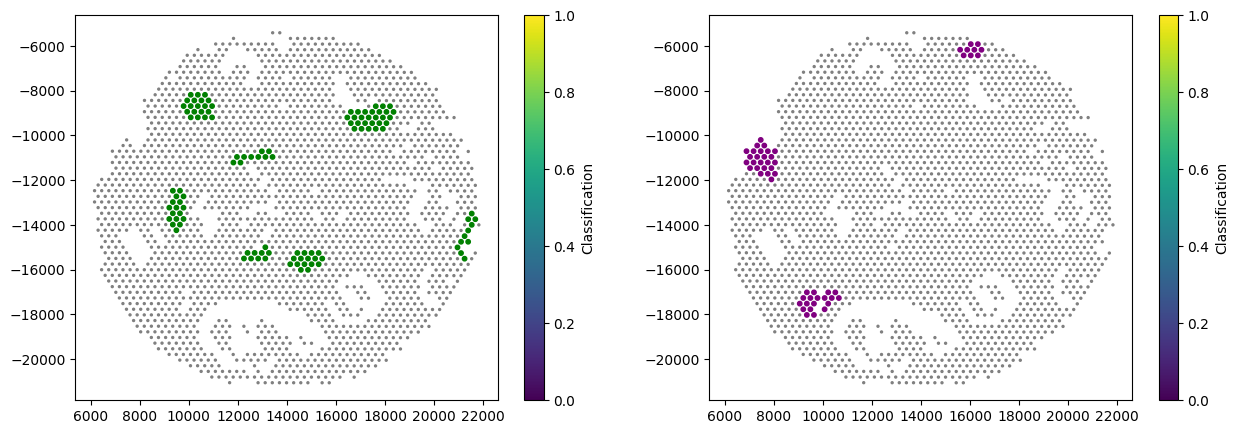

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,5))
scatter1 = ax1.scatter(data_FFPE.obs["imagecol"],-data_FFPE.obs["imagerow"],
                       c=np.where(data_FFPE.obs.index.isin(data_FFPE_cancer),"green","grey"),
                       s=np.where(data_FFPE.obs.index.isin(data_FFPE_cancer),10,2))
colorbar = plt.colorbar(scatter1, ax=ax1)
colorbar.set_label('Classification')

scatter2 = ax2.scatter(data_FFPE.obs["imagecol"],-data_FFPE.obs["imagerow"],
                       c=np.where(data_FFPE.obs.index.isin(data_FFPE_immune),"purple","gray"),
                       s=np.where(data_FFPE.obs.index.isin(data_FFPE_immune),10,2))
colorbar = plt.colorbar(scatter2, ax=ax2)
colorbar.set_label('Classification')

#### Selection of tiles

In [23]:
# diff_df_can = tile.to_df()[["CD52","VEGFA"]]-data_FFPE[data_FFPE.obs.index.isin(data_FFPE_cancer)].to_df()[["CD52","VEGFA"]]
# diff_df_imm = tile.to_df()[["CD52","VEGFA"]]-data_FFPE[data_FFPE.obs.index.isin(data_FFPE_immune)].to_df()[["CD52","VEGFA"]]

# high_can = (data_FFPE[data_FFPE.obs.index.isin(data_FFPE_cancer)].to_df()["VEGFA"]-data_FFPE[data_FFPE.obs.index.isin(data_FFPE_cancer)].to_df()["CD52"])#.sort_values(ascending=False).head(500)
# high_imm = (data_FFPE[data_FFPE.obs.index.isin(data_FFPE_immune)].to_df()["CD52"]-data_FFPE[data_FFPE.obs.index.isin(data_FFPE_immune)].to_df()["VEGFA"])#.sort_values(ascending=False).head(500)

# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.scatter(diff_df_can.dropna()["VEGFA"],high_can.sort_index())
# plt.subplot(1,2,2)
# plt.scatter(diff_df_imm.dropna()["CD52"],high_imm.sort_index())

# can_tiles = set(diff_df_can.dropna()["VEGFA"][diff_df_can.dropna()["VEGFA"]>1.0].index).intersection(set(high_can[high_can<0.5].index))
# imm_tiles = set(diff_df_imm.dropna()["VEGFA"][diff_df_imm.dropna()["VEGFA"]>1.0].index).intersection(set(high_imm[abs(high_imm)<0.5].index))

#### Randomly sampled tiles, for LIME

In [24]:
# import random
# data_FFPE_cancer_rs = random.sample(data_FFPE_cancer,25)
# data_FFPE_immune_rs = random.sample(data_FFPE_immune,25)

#### Top 5 tiles with high expression

In [6]:
can_tiles = data_FFPE[data_FFPE.obs.index.isin(data_FFPE_cancer)].to_df()["VEGFA"].sort_values(ascending=False).index[:5]
imm_tiles = data_FFPE[data_FFPE.obs.index.isin(data_FFPE_immune)].to_df()["CD52"].sort_values(ascending=False).index[:5]

### LIME Functions

In [7]:
"""
Contains abstract functionality for learning locally linear sparse model.
"""
import numpy as np
import scipy as sp
from sklearn.linear_model import Ridge, lars_path, Ridge
from sklearn.utils import check_random_state


class LimeBase(object):
    """Class for learning a locally linear sparse model from perturbed data"""
    def __init__(self,
                 kernel_fn,
                 verbose=False,
                 random_state=None):
        """Init function

        Args:
            kernel_fn: function that transforms an array of distances into an
                        array of proximity values (floats).
            verbose: if true, print local prediction values from linear model.
            random_state: an integer or numpy.RandomState that will be used to
                generate random numbers. If None, the random state will be
                initialized using the internal numpy seed.
        """
        self.kernel_fn = kernel_fn
        self.verbose = verbose
        self.random_state = check_random_state(random_state)

    @staticmethod
    def generate_lars_path(weighted_data, weighted_labels):
        """Generates the lars path for weighted data.

        Args:
            weighted_data: data that has been weighted by kernel
            weighted_label: labels, weighted by kernel

        Returns:
            (alphas, coefs), both are arrays corresponding to the
            regularization parameter and coefficients, respectively
        """
        x_vector = weighted_data
        alphas, _, coefs = lars_path(x_vector,
                                     weighted_labels,
                                     method='Ridge',
                                     verbose=False)
        return alphas, coefs

    def forward_selection(self, data, labels, weights, num_features):
        """Iteratively adds features to the model"""
        clf = Ridge(alpha=0, fit_intercept=True, random_state=self.random_state)
        used_features = []
        for _ in range(min(num_features, data.shape[1])):
            max_ = -100000000
            best = 0
            for feature in range(data.shape[1]):
                if feature in used_features:
                    continue
                clf.fit(data[:, used_features + [feature]], labels,
                        sample_weight=weights)
                score = clf.score(data[:, used_features + [feature]],
                                  labels,
                                  sample_weight=weights)
                if score > max_:
                    best = feature
                    max_ = score
            used_features.append(best)
        return np.array(used_features)

    def feature_selection(self, data, labels, weights, num_features, method):
        """Selects features for the model. see explain_instance_with_data to
           understand the parameters."""
        if method == 'none':
            return np.array(range(data.shape[1]))
        elif method == 'forward_selection':
            return self.forward_selection(data, labels, weights, num_features)
        elif method == 'highest_weights':
            clf = Ridge(alpha=0.01, fit_intercept=True,
                        random_state=self.random_state)
            clf.fit(data, labels, sample_weight=weights)

            coef = clf.coef_
            if sp.sparse.issparse(data):
                coef = sp.sparse.csr_matrix(clf.coef_)
                weighted_data = coef.multiply(data[0])
                # Note: most efficient to slice the data before reversing
                sdata = len(weighted_data.data)
                argsort_data = np.abs(weighted_data.data).argsort()
                # Edge case where data is more sparse than requested number of feature importances
                # In that case, we just pad with zero-valued features
                if sdata < num_features:
                    nnz_indexes = argsort_data[::-1]
                    indices = weighted_data.indices[nnz_indexes]
                    num_to_pad = num_features - sdata
                    indices = np.concatenate((indices, np.zeros(num_to_pad, dtype=indices.dtype)))
                    indices_set = set(indices)
                    pad_counter = 0
                    for i in range(data.shape[1]):
                        if i not in indices_set:
                            indices[pad_counter + sdata] = i
                            pad_counter += 1
                            if pad_counter >= num_to_pad:
                                break
                else:
                    nnz_indexes = argsort_data[sdata - num_features:sdata][::-1]
                    indices = weighted_data.indices[nnz_indexes]
                return indices
            else:
                weighted_data = coef * data[0]
                feature_weights = sorted(
                    zip(range(data.shape[1]), weighted_data),
                    key=lambda x: np.abs(x[1]),
                    reverse=True)
                return np.array([x[0] for x in feature_weights[:num_features]])
        elif method == 'Ridge_path':
            weighted_data = ((data - np.average(data, axis=0, weights=weights))
                             * np.sqrt(weights[:, np.newaxis]))
            weighted_labels = ((labels - np.average(labels, weights=weights))
                               * np.sqrt(weights))
            nonzero = range(weighted_data.shape[1])
            _, coefs = self.generate_lars_path(weighted_data,
                                               weighted_labels)
            for i in range(len(coefs.T) - 1, 0, -1):
                nonzero = coefs.T[i].nonzero()[0]
                if len(nonzero) <= num_features:
                    break
            used_features = nonzero
            return used_features
        elif method == 'auto':
            if num_features <= 6:
                n_method = 'forward_selection'
            else:
                n_method = 'highest_weights'
            return self.feature_selection(data, labels, weights,
                                          num_features, n_method)

    def explain_instance_with_data(self,
                                   neighborhood_data,
                                   neighborhood_labels,
                                   distances,
                                   label,
                                   num_features,
                                   feature_selection='auto',
                                   model_regressor=None):
        """Takes perturbed data, labels and distances, returns explanation.

        Args:
            neighborhood_data: perturbed data, 2d array. first element is
                               assumed to be the original data point.
            neighborhood_labels: corresponding perturbed labels. should have as
                                 many columns as the number of possible labels.
            distances: distances to original data point.
            label: label for which we want an explanation
            num_features: maximum number of features in explanation
            feature_selection: how to select num_features. options are:
                'forward_selection': iteratively add features to the model.
                    This is costly when num_features is high
                'highest_weights': selects the features that have the highest
                    product of absolute weight * original data point when
                    learning with all the features
                'Ridge_path': chooses features based on the Ridge
                    regularization path
                'none': uses all features, ignores num_features
                'auto': uses forward_selection if num_features <= 6, and
                    'highest_weights' otherwise.
            model_regressor: sklearn regressor to use in explanation.
                Defaults to Ridge regression if None. Must have
                model_regressor.coef_ and 'sample_weight' as a parameter
                to model_regressor.fit()

        Returns:
            (intercept, exp, score, local_pred):
            intercept is a float.
            exp is a sorted list of tuples, where each tuple (x,y) corresponds
            to the feature id (x) and the local weight (y). The list is sorted
            by decreasing absolute value of y.
            score is the R^2 value of the returned explanation
            local_pred is the prediction of the explanation model on the original instance
        """

        weights = self.kernel_fn(distances)
        labels_column = neighborhood_labels[:, label]
        used_features = self.feature_selection(neighborhood_data,
                                               labels_column,
                                               weights,
                                               num_features,
                                               feature_selection)
        if model_regressor is None:
            model_regressor = Ridge(alpha=1, fit_intercept=True,
                                    random_state=self.random_state)
        easy_model = model_regressor
        easy_model.fit(neighborhood_data[:, used_features],
                       labels_column, sample_weight=weights)
        prediction_score = easy_model.score(
            neighborhood_data[:, used_features],
            labels_column, sample_weight=weights)

        local_pred = easy_model.predict(neighborhood_data[0, used_features].reshape(1, -1))

        if self.verbose:
            print('Intercept', easy_model.intercept_)
            print('Prediction_local', local_pred,)
            print('Right:', neighborhood_labels[0, label])
        return (easy_model.intercept_,
                sorted(zip(used_features, easy_model.coef_),
                       key=lambda x: np.abs(x[1]), reverse=True),
                prediction_score, local_pred)
    

"""
Functions for explaining classifiers that use Image data.
"""
import copy
from functools import partial
import numpy as np
import sklearn
from sklearn.utils import check_random_state
from skimage.color import gray2rgb
from tqdm.auto import tqdm



class ImageExplanation(object):
    def __init__(self, image, segments):
        """Init function.

        Args:
            image: 3d numpy array
            segments: 2d numpy array, with the output from skimage.segmentation
        """
        self.image = image
        self.segments = segments
        self.intercept = {}
        self.local_exp = {}
        self.local_pred = {}
        self.score = {}

    def get_image_and_mask(self, label, positive_only=True, negative_only=False, hide_rest=False,
                           num_features=5, min_weight=0.):
        """Init function.

        Args:
            label: label to explain
            positive_only: if True, only take superpixels that positively contribute to
                the prediction of the label.
            negative_only: if True, only take superpixels that negatively contribute to
                the prediction of the label. If false, and so is positive_only, then both
                negativey and positively contributions will be taken.
                Both can't be True at the same time
            hide_rest: if True, make the non-explanation part of the return
                image gray
            num_features: number of superpixels to include in explanation
            min_weight: minimum weight of the superpixels to include in explanation

        Returns:
            (image, mask), where image is a 3d numpy array and mask is a 2d
            numpy array that can be used with
            skimage.segmentation.mark_boundaries
        """
        if label not in self.local_exp:
            raise KeyError('Label not in explanation')
        if positive_only & negative_only:
            raise ValueError("Positive_only and negative_only cannot be true at the same time.")
        segments = self.segments
        image = self.image
        exp = self.local_exp[label]
        mask = np.zeros(segments.shape, segments.dtype)
        if hide_rest:
            temp = np.zeros(self.image.shape)
        else:
            temp = self.image.copy()
        if positive_only:
            fs = [x[0] for x in exp
                  if x[1] > 0 and x[1] > min_weight][:num_features]
        if negative_only:
            fs = [x[0] for x in exp
                  if x[1] < 0 and abs(x[1]) > min_weight][:num_features]
        if positive_only or negative_only:
            for f in fs:
                temp[segments == f] = image[segments == f].copy()
                mask[segments == f] = 1
            return temp, mask
        else:
            for f, w in exp[:num_features]:
                if np.abs(w) < min_weight:
                    continue
                c = 0 if w < 0 else 1
                mask[segments == f] = -1 if w < 0 else 1
                temp[segments == f] = image[segments == f].copy()
                temp[segments == f, c] = np.max(image)
            return temp, mask


class LimeImageExplainer(object):
    """Explains predictions on Image (i.e. matrix) data.
    For numerical features, perturb them by sampling from a Normal(0,1) and
    doing the inverse operation of mean-centering and scaling, according to the
    means and stds in the training data. For categorical features, perturb by
    sampling according to the training distribution, and making a binary
    feature that is 1 when the value is the same as the instance being
    explained."""

    def __init__(self, kernel_width=.25, kernel=None, verbose=False,
                 feature_selection='auto', random_state=None):
        """Init function.

        Args:
            kernel_width: kernel width for the exponential kernel.
            If None, defaults to sqrt(number of columns) * 0.75.
            kernel: similarity kernel that takes euclidean distances and kernel
                width as input and outputs weights in (0,1). If None, defaults to
                an exponential kernel.
            verbose: if true, print local prediction values from linear model
            feature_selection: feature selection method. can be
                'forward_selection', 'Ridge_path', 'none' or 'auto'.
                See function 'explain_instance_with_data' in lime_base.py for
                details on what each of the options does.
            random_state: an integer or numpy.RandomState that will be used to
                generate random numbers. If None, the random state will be
                initialized using the internal numpy seed.
        """
        kernel_width = float(kernel_width)

        if kernel is None:
            def kernel(d, kernel_width):
                return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

        kernel_fn = partial(kernel, kernel_width=kernel_width)

        self.random_state = check_random_state(random_state)
        self.feature_selection = feature_selection
        self.base = LimeBase(kernel_fn, verbose, random_state=self.random_state)

    def explain_instance(self, image, classifier_fn, labels=(1,),
                         hide_color=None,
                         top_labels=5, num_features=100000, num_samples=1000,
                         batch_size=10,
                         segmentation_fn=None,
                         distance_metric='cosine',
                         model_regressor=None,
                         random_seed=None,
                         progress_bar=True):
        """Generates explanations for a prediction.

        First, we generate neighborhood data by randomly perturbing features
        from the instance (see __data_inverse). We then learn locally weighted
        linear models on this neighborhood data to explain each of the classes
        in an interpretable way (see lime_base.py).

        Args:
            image: 3 dimension RGB image. If this is only two dimensional,
                we will assume it's a grayscale image and call gray2rgb.
            classifier_fn: classifier prediction probability function, which
                takes a numpy array and outputs prediction probabilities.  For
                ScikitClassifiers , this is classifier.predict_proba.
            labels: iterable with labels to be explained.
            hide_color: If not None, will hide superpixels with this color.
                Otherwise, use the mean pixel color of the image.
            top_labels: if not None, ignore labels and produce explanations for
                the K labels with highest prediction probabilities, where K is
                this parameter.
            num_features: maximum number of features present in explanation
            num_samples: size of the neighborhood to learn the linear model
            batch_size: batch size for model predictions
            distance_metric: the distance metric to use for weights.
            model_regressor: sklearn regressor to use in explanation. Defaults
            to Ridge regression in LimeBase. Must have model_regressor.coef_
            and 'sample_weight' as a parameter to model_regressor.fit()
            segmentation_fn: SegmentationAlgorithm, wrapped skimage
            segmentation function
            random_seed: integer used as random seed for the segmentation
                algorithm. If None, a random integer, between 0 and 1000,
                will be generated using the internal random number generator.
            progress_bar: if True, show tqdm progress bar.

        Returns:
            An ImageExplanation object (see lime_image.py) with the corresponding
            explanations.
        """
        if len(image.shape) == 2:
            image = gray2rgb(image)
        if random_seed is None:
            random_seed = self.random_state.randint(0, high=1000)

        if segmentation_fn is None:
            segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4,
                                                    max_dist=200, ratio=0.2,
                                                    random_seed=random_seed)
        segments = segmentation_fn(image)

        fudged_image = image.copy()
        if hide_color is None:
            for x in np.unique(segments):
                fudged_image[segments == x] = (
                    np.mean(image[segments == x][:, 0]),
                    np.mean(image[segments == x][:, 1]),
                    np.mean(image[segments == x][:, 2]))
        else:
            fudged_image[:] = hide_color

        top = labels

        data, img_cpy, segments, labels = self.data_labels(image, fudged_image, segments,
                                        classifier_fn, num_samples,
                                        batch_size=batch_size,
                                        progress_bar=progress_bar)

        distances = sklearn.metrics.pairwise_distances(
            data,
            data[0].reshape(1, -1),
            metric=distance_metric
        ).ravel()

        ret_exp = ImageExplanation(image, segments)
        if top_labels:
            top = np.argsort(labels[0])[-top_labels:]
            ret_exp.top_labels = list(top)
            ret_exp.top_labels.reverse()
        for label in top:
            (ret_exp.intercept[label],
             ret_exp.local_exp[label],
             ret_exp.score[label],
             ret_exp.local_pred[label]) = self.base.explain_instance_with_data(
                data, labels, distances, label, num_features,
                model_regressor=model_regressor,
                feature_selection=self.feature_selection)
        return ret_exp, data, img_cpy, segments, np.array(labels)

    def data_labels(self,
                    image,
                    fudged_image,
                    segments,
                    classifier_fn,
                    num_samples,
                    batch_size=10,
                    progress_bar=True):
        """Generates images and predictions in the neighborhood of this image.

        Args:
            image: 3d numpy array, the image
            fudged_image: 3d numpy array, image to replace original image when
                superpixel is turned off
            segments: segmentation of the image
            classifier_fn: function that takes a list of images and returns a
                matrix of prediction probabilities
            num_samples: size of the neighborhood to learn the linear model
            batch_size: classifier_fn will be called on batches of this size.
            progress_bar: if True, show tqdm progress bar.

        Returns:
            A tuple (data, labels), where:
                data: dense num_samples * num_superpixels
                labels: prediction probabilities matrix
        """
        n_features = np.unique(segments).shape[0]
        data = self.random_state.randint(0, 2, num_samples * n_features)\
            .reshape((num_samples, n_features))
        labels = []
        data[0, :] = 1
        imgs = []
        rows = tqdm(data) if progress_bar else data
        for row in rows:
            temp = copy.deepcopy(image)
            zeros = np.where(row == 0)[0]
            mask = np.zeros(segments.shape).astype(bool)
            
            for z in zeros:
                if z!=0:
                    mask[segments == z] = True
                    
            temp[mask] = fudged_image[mask]
            
#             plt.figure(figsize=(5,5))
#             plt.subplot(1,2,1)
#             plt.imshow(temp)
            imgs.append(temp)
            
#             imgs = [img for img in imgs if np.mean(img) > 50]
#             imgs = random.sample(imgs, num_samples)
#             filtered_images = [(i, img) for i, img in enumerate(imgs) if np.mean(img) > 50]
#             filtered_indices = [i for i, img in filtered_images]
#             imgplt = [img for i, img in filtered_images]

            imgs_cpy = copy.deepcopy(imgs)
            if len(imgs) == batch_size:
                preds = classifier_fn(np.array(imgs))
                labels.extend(preds)
                imgs = []
        if len(imgs) > 0:
            preds = classifier_fn(np.array(imgs))
            labels.extend(preds)            
        return data, imgs_cpy, segments, np.array(labels)

In [8]:
def LIME_reg_exceptional_handling(image_path, gene):
    LIME_heatmaps = []; no_segments = []
    for i in image_path:
        image = np.asarray(image_fun.load_img(i))
        try:
            explanation, d, m, s, l = explainer.explain_instance(image,
                                                                 model_predict_gene_reg(gene),
                                                                 top_labels=1,
                                                                 hide_color=0,
                                                                 num_samples=500,
                                                                 segmentation_fn=cellpose_segments)
            dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
            heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
        except:
            no_segments.append(i)
            print(f"Error generating LIME explanation for image: {i}")  
            heatmap = np.full((299, 299), 2)
        LIME_heatmaps.append(heatmap)
    print(f"Images with segmentation issues: {no_segments}")
    return LIME_heatmaps, image_path

In [17]:
explainer = LimeImageExplainer()

In [11]:
LIMEMask_FFPE_CDH1_cancer, image_path = LIME_reg_exceptional_handling(list(tile[tile.obs.index.isin(data_FFPE_cancer_rs)].obs["tile_path"].values),
                                                   gene_list[541])

2024-08-20 18:22:23,834 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:22:23,837 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:22:23,839 [INFO] >>>> using CPU
2024-08-20 18:22:23,840 [INFO] >> nuclei << model set to be used
2024-08-20 18:22:23,945 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:22:24,657 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:22:24,660 [INFO] channels set to [[0, 0]]
2024-08-20 18:22:24,661 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:22:35,277 [INFO] >>>> TOTAL TIME 10.62 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-20 18:25:15,689 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:25:15,689 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:25:15,690 [INFO] >>>> using CPU
2024-08-20 18:25:15,691 [INFO] >> nuclei << model set to be used
2024-08-20 18:25:15,748 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:25:16,663 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:25:16,665 [INFO] channels set to [[0, 0]]
2024-08-20 18:25:16,665 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:25:25,742 [INFO] >>>> TOTAL TIME 9.08 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-20 18:27:12,570 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:27:12,571 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:27:12,572 [INFO] >>>> using CPU
2024-08-20 18:27:12,572 [INFO] >> nuclei << model set to be used
2024-08-20 18:27:12,631 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:27:13,191 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:27:13,199 [INFO] channels set to [[0, 0]]
2024-08-20 18:27:13,200 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:27:21,284 [INFO] >>>> TOTAL TIME 8.08 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-20 18:29:01,438 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:29:01,439 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:29:01,440 [INFO] >>>> using CPU
2024-08-20 18:29:01,440 [INFO] >> nuclei << model set to be used
2024-08-20 18:29:01,519 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:29:02,094 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:29:02,096 [INFO] channels set to [[0, 0]]
2024-08-20 18:29:02,097 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:29:10,976 [INFO] >>>> TOTAL TIME 8.88 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-20 18:30:44,597 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:30:44,600 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:30:44,601 [INFO] >>>> using CPU
2024-08-20 18:30:44,602 [INFO] >> nuclei << model set to be used
2024-08-20 18:30:44,682 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:30:45,288 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:30:45,292 [INFO] channels set to [[0, 0]]
2024-08-20 18:30:45,294 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:30:53,597 [INFO] >>>> TOTAL TIME 8.30 sec


  0%|          | 0/500 [00:00<?, ?it/s]

Images with segmentation issues: []


In [12]:
LIMEMask_FFPE_CDH1_immune, image_path = LIME_reg_exceptional_handling(list(tile[tile.obs.index.isin(data_FFPE_immune_rs)].obs["tile_path"].values),
                                                   gene_list[541])

2024-08-20 18:32:27,995 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:32:27,996 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:32:27,996 [INFO] >>>> using CPU
2024-08-20 18:32:27,997 [INFO] >> nuclei << model set to be used
2024-08-20 18:32:28,067 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:32:28,591 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:32:28,599 [INFO] channels set to [[0, 0]]
2024-08-20 18:32:28,600 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:32:37,773 [INFO] >>>> TOTAL TIME 9.17 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-20 18:34:20,005 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:34:20,008 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:34:20,009 [INFO] >>>> using CPU
2024-08-20 18:34:20,012 [INFO] >> nuclei << model set to be used
2024-08-20 18:34:20,072 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:34:20,869 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:34:20,877 [INFO] channels set to [[0, 0]]
2024-08-20 18:34:20,882 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:34:30,850 [INFO] >>>> TOTAL TIME 9.97 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-20 18:36:04,960 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:36:04,961 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:36:04,962 [INFO] >>>> using CPU
2024-08-20 18:36:04,963 [INFO] >> nuclei << model set to be used
2024-08-20 18:36:05,016 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:36:05,546 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:36:05,549 [INFO] channels set to [[0, 0]]
2024-08-20 18:36:05,551 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:36:15,892 [INFO] >>>> TOTAL TIME 10.34 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-20 18:38:08,218 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:38:08,219 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:38:08,219 [INFO] >>>> using CPU
2024-08-20 18:38:08,221 [INFO] >> nuclei << model set to be used
2024-08-20 18:38:08,278 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:38:08,850 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:38:08,856 [INFO] channels set to [[0, 0]]
2024-08-20 18:38:08,857 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:38:18,322 [INFO] >>>> TOTAL TIME 9.47 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-20 18:40:11,734 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:40:11,735 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:40:11,736 [INFO] >>>> using CPU
2024-08-20 18:40:11,736 [INFO] >> nuclei << model set to be used
2024-08-20 18:40:11,817 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:40:12,476 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:40:12,479 [INFO] channels set to [[0, 0]]
2024-08-20 18:40:12,481 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:40:18,858 [INFO] >>>> TOTAL TIME 6.38 sec


  0%|          | 0/500 [00:00<?, ?it/s]

Images with segmentation issues: []


In [13]:
LIMEMask_FFPE_CD52_cancer, image_path = LIME_reg_exceptional_handling(list(tile[tile.obs.index.isin(data_FFPE_cancer_rs)].obs["tile_path"].values),
                                                   gene_list[26])

2024-08-20 18:42:16,121 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:42:16,122 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:42:16,122 [INFO] >>>> using CPU
2024-08-20 18:42:16,123 [INFO] >> nuclei << model set to be used
2024-08-20 18:42:16,171 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:42:16,804 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:42:16,812 [INFO] channels set to [[0, 0]]
2024-08-20 18:42:16,823 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:42:26,175 [INFO] >>>> TOTAL TIME 9.36 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-20 18:44:26,543 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:44:26,544 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:44:26,545 [INFO] >>>> using CPU
2024-08-20 18:44:26,545 [INFO] >> nuclei << model set to be used
2024-08-20 18:44:26,634 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:44:27,457 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:44:27,464 [INFO] channels set to [[0, 0]]
2024-08-20 18:44:27,469 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:44:36,938 [INFO] >>>> TOTAL TIME 9.47 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-20 18:46:34,023 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:46:34,024 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:46:34,025 [INFO] >>>> using CPU
2024-08-20 18:46:34,026 [INFO] >> nuclei << model set to be used
2024-08-20 18:46:34,093 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:46:34,749 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:46:34,756 [INFO] channels set to [[0, 0]]
2024-08-20 18:46:34,757 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:46:43,223 [INFO] >>>> TOTAL TIME 8.47 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-20 18:48:36,925 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:48:36,926 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:48:36,927 [INFO] >>>> using CPU
2024-08-20 18:48:36,928 [INFO] >> nuclei << model set to be used
2024-08-20 18:48:37,023 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:48:37,591 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:48:37,598 [INFO] channels set to [[0, 0]]
2024-08-20 18:48:37,599 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:48:45,762 [INFO] >>>> TOTAL TIME 8.16 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-20 18:50:33,040 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:50:33,041 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:50:33,042 [INFO] >>>> using CPU
2024-08-20 18:50:33,043 [INFO] >> nuclei << model set to be used
2024-08-20 18:50:33,103 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:50:33,668 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:50:33,676 [INFO] channels set to [[0, 0]]
2024-08-20 18:50:33,676 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:50:41,475 [INFO] >>>> TOTAL TIME 7.80 sec


  0%|          | 0/500 [00:00<?, ?it/s]

Images with segmentation issues: []


In [14]:
LIMEMask_FFPE_CD52_immune, image_path = LIME_reg_exceptional_handling(list(tile[tile.obs.index.isin(data_FFPE_immune_rs)].obs["tile_path"].values),
                                                   gene_list[26])

2024-08-20 18:52:23,053 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:52:23,054 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:52:23,055 [INFO] >>>> using CPU
2024-08-20 18:52:23,056 [INFO] >> nuclei << model set to be used
2024-08-20 18:52:23,107 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:52:23,649 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:52:23,652 [INFO] channels set to [[0, 0]]
2024-08-20 18:52:23,653 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:52:26,779 [INFO] >>>> TOTAL TIME 3.13 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-20 18:53:23,222 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:53:23,223 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:53:23,224 [INFO] >>>> using CPU
2024-08-20 18:53:23,225 [INFO] >> nuclei << model set to be used
2024-08-20 18:53:23,284 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:53:23,505 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:53:23,512 [INFO] channels set to [[0, 0]]
2024-08-20 18:53:23,513 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:53:24,069 [INFO] >>>> TOTAL TIME 0.56 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-20 18:54:19,316 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:54:19,317 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:54:19,317 [INFO] >>>> using CPU
2024-08-20 18:54:19,318 [INFO] >> nuclei << model set to be used
2024-08-20 18:54:19,376 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:54:19,908 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:54:19,910 [INFO] channels set to [[0, 0]]
2024-08-20 18:54:19,911 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:54:21,943 [INFO] >>>> TOTAL TIME 2.03 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-20 18:55:18,119 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:55:18,120 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:55:18,120 [INFO] >>>> using CPU
2024-08-20 18:55:18,121 [INFO] >> nuclei << model set to be used
2024-08-20 18:55:18,177 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:55:18,403 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:55:18,410 [INFO] channels set to [[0, 0]]
2024-08-20 18:55:18,410 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:55:19,051 [INFO] >>>> TOTAL TIME 0.64 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-20 18:56:11,628 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-20 18:56:11,629 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-20 18:56:11,629 [INFO] >>>> using CPU
2024-08-20 18:56:11,630 [INFO] >> nuclei << model set to be used
2024-08-20 18:56:11,688 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-20 18:56:12,227 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-20 18:56:12,230 [INFO] channels set to [[0, 0]]
2024-08-20 18:56:12,231 [INFO] ~~~ FINDING MASKS ~~~
2024-08-20 18:56:15,646 [INFO] >>>> TOTAL TIME 3.42 sec


  0%|          | 0/500 [00:00<?, ?it/s]

Images with segmentation issues: []


In [9]:
LIMEMask_FFPE_VEGFA_immune, image_path = LIME_reg_exceptional_handling(immune_tiles,
                                                   gene_list[541])

2024-08-27 10:50:52,316 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 10:50:52,317 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 10:50:52,317 [INFO] >>>> using CPU
2024-08-27 10:50:52,318 [INFO] >> nuclei << model set to be used
2024-08-27 10:50:52,369 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 10:50:52,855 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 10:50:52,863 [INFO] channels set to [[0, 0]]
2024-08-27 10:50:52,864 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 10:50:59,641 [INFO] >>>> TOTAL TIME 6.78 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 10:51:45,288 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 10:51:45,289 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 10:51:45,289 [INFO] >>>> using CPU
2024-08-27 10:51:45,290 [INFO] >> nuclei << model set to be used
2024-08-27 10:51:45,362 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 10:51:45,788 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 10:51:45,789 [INFO] channels set to [[0, 0]]
2024-08-27 10:51:45,790 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 10:51:52,279 [INFO] >>>> TOTAL TIME 6.49 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 10:52:20,861 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 10:52:20,862 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 10:52:20,862 [INFO] >>>> using CPU
2024-08-27 10:52:20,862 [INFO] >> nuclei << model set to be used
2024-08-27 10:52:20,895 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 10:52:21,312 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 10:52:21,313 [INFO] channels set to [[0, 0]]
2024-08-27 10:52:21,314 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 10:52:27,855 [INFO] >>>> TOTAL TIME 6.54 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 10:52:56,259 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 10:52:56,259 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 10:52:56,260 [INFO] >>>> using CPU
2024-08-27 10:52:56,260 [INFO] >> nuclei << model set to be used
2024-08-27 10:52:56,293 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 10:52:56,723 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 10:52:56,726 [INFO] channels set to [[0, 0]]
2024-08-27 10:52:56,726 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 10:53:03,356 [INFO] >>>> TOTAL TIME 6.63 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 10:53:31,773 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 10:53:31,774 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 10:53:31,775 [INFO] >>>> using CPU
2024-08-27 10:53:31,775 [INFO] >> nuclei << model set to be used
2024-08-27 10:53:31,834 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 10:53:32,261 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 10:53:32,264 [INFO] channels set to [[0, 0]]
2024-08-27 10:53:32,264 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 10:53:38,835 [INFO] >>>> TOTAL TIME 6.57 sec


  0%|          | 0/500 [00:00<?, ?it/s]

Images with segmentation issues: []


In [10]:
LIMEMask_FFPE_VEGFA_cancer, image_path = LIME_reg_exceptional_handling(cancer_tiles,
                                                   gene_list[541])

2024-08-27 10:54:07,422 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 10:54:07,423 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 10:54:07,423 [INFO] >>>> using CPU
2024-08-27 10:54:07,424 [INFO] >> nuclei << model set to be used
2024-08-27 10:54:07,484 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 10:54:07,926 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 10:54:07,931 [INFO] channels set to [[0, 0]]
2024-08-27 10:54:07,932 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 10:54:14,514 [INFO] >>>> TOTAL TIME 6.58 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 10:54:42,556 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 10:54:42,556 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 10:54:42,557 [INFO] >>>> using CPU
2024-08-27 10:54:42,557 [INFO] >> nuclei << model set to be used
2024-08-27 10:54:42,591 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 10:54:43,015 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 10:54:43,017 [INFO] channels set to [[0, 0]]
2024-08-27 10:54:43,018 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 10:54:49,584 [INFO] >>>> TOTAL TIME 6.57 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 10:55:17,500 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 10:55:17,501 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 10:55:17,501 [INFO] >>>> using CPU
2024-08-27 10:55:17,501 [INFO] >> nuclei << model set to be used
2024-08-27 10:55:17,532 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 10:55:17,986 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 10:55:17,988 [INFO] channels set to [[0, 0]]
2024-08-27 10:55:17,989 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 10:55:24,612 [INFO] >>>> TOTAL TIME 6.62 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 10:55:55,154 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 10:55:55,154 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 10:55:55,155 [INFO] >>>> using CPU
2024-08-27 10:55:55,155 [INFO] >> nuclei << model set to be used
2024-08-27 10:55:55,225 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 10:55:55,943 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 10:55:55,945 [INFO] channels set to [[0, 0]]
2024-08-27 10:55:55,945 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 10:56:03,316 [INFO] >>>> TOTAL TIME 7.37 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 10:56:38,025 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 10:56:38,026 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 10:56:38,026 [INFO] >>>> using CPU
2024-08-27 10:56:38,026 [INFO] >> nuclei << model set to be used
2024-08-27 10:56:38,070 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 10:56:38,592 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 10:56:38,600 [INFO] channels set to [[0, 0]]
2024-08-27 10:56:38,602 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 10:56:45,309 [INFO] >>>> TOTAL TIME 6.71 sec


  0%|          | 0/500 [00:00<?, ?it/s]

Images with segmentation issues: []


In [11]:
# np.save(Path+"pickle/npy/LIMEMaskReg_FFPE_VEGFA_cancer.npy",LIMEMask_FFPE_VEGFA_cancer)
# np.save(Path+"pickle/npy/LIMEMaskReg_FFPE_VEGFA_immune.npy",LIMEMask_FFPE_VEGFA_immune)

# import pickle

# with open(Path+"pickle/npy/"+'FFPE_cancer_paths_25.pkl', 'wb') as file:
#     pickle.dump(list(tile[tile.obs.index.isin(data_FFPE_cancer_rs)].obs["tile_path"].values), file)
# with open(Path+"pickle/npy/"+'FFPE_immune_paths_25.pkl', 'wb') as file:
#     pickle.dump(list(tile[tile.obs.index.isin(data_FFPE_immune_rs)].obs["tile_path"].values), file)
    
# np.save(Path+"pickle/npy/LIMEMaskReg_FFPE_CD52_cancer_25.npy",LIMEMask_FFPE_CD52_cancer)
# np.save(Path+"pickle/npy/LIMEMaskReg_FFPE_VEGFA_cancer_25.npy",LIMEMask_FFPE_VEGFA_cancer)
# np.save(Path+"pickle/npy/LIMEMaskReg_FFPE_CD52_immune_25.npy",LIMEMask_FFPE_CD52_immune)
# np.save(Path+"pickle/npy/LIMEMaskReg_FFPE_VEGFA_immune_25.npy",LIMEMask_FFPE_VEGFA_immune)

#### LIME scores for good tiles

In [9]:
explainer = LimeImageExplainer()
can_tiles = tile[tile.obs.index.isin(list(can_tiles))].obs["tile_path"]
imm_tiles = tile[tile.obs.index.isin(list(imm_tiles))].obs["tile_path"]

In [10]:
LIMEMask_FFPE_VEGFA_cancer, image_path = LIME_reg_exceptional_handling(list(can_tiles),
                                                   gene_list[541])
LIMEMask_FFPE_VEGFA_immune, image_path = LIME_reg_exceptional_handling(list(imm_tiles),
                                                   gene_list[541])

LIMEMask_FFPE_CD52_cancer, image_path = LIME_reg_exceptional_handling(list(can_tiles),
                                                   gene_list[26])
LIMEMask_FFPE_CD52_immune, image_path = LIME_reg_exceptional_handling(list(imm_tiles),
                                                   gene_list[26])

2024-08-27 18:49:57,869 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 18:49:57,870 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 18:49:57,870 [INFO] >>>> using CPU
2024-08-27 18:49:57,871 [INFO] >> nuclei << model set to be used
2024-08-27 18:49:57,928 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 18:49:58,602 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 18:49:58,604 [INFO] channels set to [[0, 0]]
2024-08-27 18:49:58,604 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 18:50:01,395 [INFO] >>>> TOTAL TIME 2.79 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 18:51:12,856 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 18:51:12,857 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 18:51:12,858 [INFO] >>>> using CPU
2024-08-27 18:51:12,858 [INFO] >> nuclei << model set to be used
2024-08-27 18:51:12,926 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 18:51:13,163 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 18:51:13,165 [INFO] channels set to [[0, 0]]
2024-08-27 18:51:13,165 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 18:51:16,176 [INFO] >>>> TOTAL TIME 3.01 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 18:52:03,205 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 18:52:03,207 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 18:52:03,208 [INFO] >>>> using CPU
2024-08-27 18:52:03,209 [INFO] >> nuclei << model set to be used
2024-08-27 18:52:03,279 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 18:52:03,536 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 18:52:03,538 [INFO] channels set to [[0, 0]]
2024-08-27 18:52:03,539 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 18:52:06,380 [INFO] >>>> TOTAL TIME 2.84 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 18:52:53,448 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 18:52:53,449 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 18:52:53,451 [INFO] >>>> using CPU
2024-08-27 18:52:53,451 [INFO] >> nuclei << model set to be used
2024-08-27 18:52:53,539 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 18:52:54,083 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 18:52:54,084 [INFO] channels set to [[0, 0]]
2024-08-27 18:52:54,085 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 18:52:56,472 [INFO] >>>> TOTAL TIME 2.39 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 18:53:43,154 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 18:53:43,155 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 18:53:43,155 [INFO] >>>> using CPU
2024-08-27 18:53:43,156 [INFO] >> nuclei << model set to be used
2024-08-27 18:53:43,210 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 18:53:43,429 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 18:53:43,431 [INFO] channels set to [[0, 0]]
2024-08-27 18:53:43,431 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 18:53:45,841 [INFO] >>>> TOTAL TIME 2.41 sec


  0%|          | 0/500 [00:00<?, ?it/s]

Images with segmentation issues: []
2024-08-27 18:54:31,817 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 18:54:31,818 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 18:54:31,819 [INFO] >>>> using CPU
2024-08-27 18:54:31,820 [INFO] >> nuclei << model set to be used
2024-08-27 18:54:31,886 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 18:54:32,140 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 18:54:32,146 [INFO] channels set to [[0, 0]]
2024-08-27 18:54:32,147 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 18:54:35,097 [INFO] >>>> TOTAL TIME 2.95 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 18:55:21,338 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 18:55:21,339 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 18:55:21,340 [INFO] >>>> using CPU
2024-08-27 18:55:21,341 [INFO] >> nuclei << model set to be used
2024-08-27 18:55:21,504 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 18:55:21,728 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 18:55:21,734 [INFO] channels set to [[0, 0]]
2024-08-27 18:55:21,735 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 18:55:24,528 [INFO] >>>> TOTAL TIME 2.79 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 18:56:13,586 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 18:56:13,587 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 18:56:13,588 [INFO] >>>> using CPU
2024-08-27 18:56:13,588 [INFO] >> nuclei << model set to be used
2024-08-27 18:56:13,642 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 18:56:14,175 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 18:56:14,176 [INFO] channels set to [[0, 0]]
2024-08-27 18:56:14,176 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 18:56:16,316 [INFO] >>>> TOTAL TIME 2.14 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 18:57:04,233 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 18:57:04,235 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 18:57:04,236 [INFO] >>>> using CPU
2024-08-27 18:57:04,237 [INFO] >> nuclei << model set to be used
2024-08-27 18:57:04,323 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 18:57:04,756 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 18:57:04,759 [INFO] channels set to [[0, 0]]
2024-08-27 18:57:04,761 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 18:57:07,249 [INFO] >>>> TOTAL TIME 2.49 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 18:57:54,328 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 18:57:54,329 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 18:57:54,329 [INFO] >>>> using CPU
2024-08-27 18:57:54,330 [INFO] >> nuclei << model set to be used
2024-08-27 18:57:54,376 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 18:57:54,972 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 18:57:54,974 [INFO] channels set to [[0, 0]]
2024-08-27 18:57:54,974 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 18:57:58,376 [INFO] >>>> TOTAL TIME 3.40 sec


  0%|          | 0/500 [00:00<?, ?it/s]

Images with segmentation issues: []
2024-08-27 18:58:44,848 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 18:58:44,859 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 18:58:44,864 [INFO] >>>> using CPU
2024-08-27 18:58:44,873 [INFO] >> nuclei << model set to be used
2024-08-27 18:58:44,936 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 18:58:45,235 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 18:58:45,243 [INFO] channels set to [[0, 0]]
2024-08-27 18:58:45,244 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 18:58:47,662 [INFO] >>>> TOTAL TIME 2.42 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 18:59:34,861 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 18:59:34,862 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 18:59:34,862 [INFO] >>>> using CPU
2024-08-27 18:59:34,863 [INFO] >> nuclei << model set to be used
2024-08-27 18:59:36,097 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 18:59:36,306 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 18:59:36,308 [INFO] channels set to [[0, 0]]
2024-08-27 18:59:36,308 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 18:59:39,648 [INFO] >>>> TOTAL TIME 3.34 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 19:00:25,903 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 19:00:25,910 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 19:00:25,912 [INFO] >>>> using CPU
2024-08-27 19:00:25,913 [INFO] >> nuclei << model set to be used
2024-08-27 19:00:25,977 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 19:00:26,465 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 19:00:26,467 [INFO] channels set to [[0, 0]]
2024-08-27 19:00:26,467 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 19:00:28,962 [INFO] >>>> TOTAL TIME 2.50 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 19:01:14,975 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 19:01:14,975 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 19:01:14,976 [INFO] >>>> using CPU
2024-08-27 19:01:14,976 [INFO] >> nuclei << model set to be used
2024-08-27 19:01:15,031 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 19:01:15,288 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 19:01:15,290 [INFO] channels set to [[0, 0]]
2024-08-27 19:01:15,291 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 19:01:18,038 [INFO] >>>> TOTAL TIME 2.75 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 19:02:02,970 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 19:02:02,972 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 19:02:02,973 [INFO] >>>> using CPU
2024-08-27 19:02:02,975 [INFO] >> nuclei << model set to be used
2024-08-27 19:02:03,060 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 19:02:03,560 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 19:02:03,561 [INFO] channels set to [[0, 0]]
2024-08-27 19:02:03,562 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 19:02:06,043 [INFO] >>>> TOTAL TIME 2.48 sec


  0%|          | 0/500 [00:00<?, ?it/s]

Images with segmentation issues: []
2024-08-27 19:02:51,617 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 19:02:51,618 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 19:02:51,619 [INFO] >>>> using CPU
2024-08-27 19:02:51,620 [INFO] >> nuclei << model set to be used
2024-08-27 19:02:51,673 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 19:02:52,260 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 19:02:52,264 [INFO] channels set to [[0, 0]]
2024-08-27 19:02:52,267 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 19:02:55,621 [INFO] >>>> TOTAL TIME 3.36 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 19:03:42,278 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 19:03:42,278 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 19:03:42,279 [INFO] >>>> using CPU
2024-08-27 19:03:42,279 [INFO] >> nuclei << model set to be used
2024-08-27 19:03:42,335 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 19:03:42,563 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 19:03:42,566 [INFO] channels set to [[0, 0]]
2024-08-27 19:03:42,569 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 19:03:45,502 [INFO] >>>> TOTAL TIME 2.94 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 19:04:31,480 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 19:04:31,482 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 19:04:31,483 [INFO] >>>> using CPU
2024-08-27 19:04:31,485 [INFO] >> nuclei << model set to be used
2024-08-27 19:04:31,565 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 19:04:31,812 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 19:04:31,814 [INFO] channels set to [[0, 0]]
2024-08-27 19:04:31,814 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 19:04:34,948 [INFO] >>>> TOTAL TIME 3.13 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 19:05:07,505 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 19:05:07,505 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 19:05:07,506 [INFO] >>>> using CPU
2024-08-27 19:05:07,506 [INFO] >> nuclei << model set to be used
2024-08-27 19:05:07,561 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 19:05:07,719 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 19:05:07,725 [INFO] channels set to [[0, 0]]
2024-08-27 19:05:07,725 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 19:05:08,010 [INFO] >>>> TOTAL TIME 0.29 sec


  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-27 19:05:36,898 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-27 19:05:36,898 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-27 19:05:36,899 [INFO] >>>> using CPU
2024-08-27 19:05:36,899 [INFO] >> nuclei << model set to be used
2024-08-27 19:05:36,933 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-27 19:05:37,389 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-27 19:05:37,391 [INFO] channels set to [[0, 0]]
2024-08-27 19:05:37,391 [INFO] ~~~ FINDING MASKS ~~~
2024-08-27 19:05:38,103 [INFO] >>>> TOTAL TIME 0.71 sec


  0%|          | 0/500 [00:00<?, ?it/s]

Images with segmentation issues: []


In [19]:
import pickle 

with open(Path+"pickle/npy/"+'FFPE_cancer_paths_new5.pkl', 'wb') as file:
    pickle.dump(list(can_tiles.values), file)
with open(Path+"pickle/npy/"+'FFPE_immune_paths_new5.pkl', 'wb') as file:
    pickle.dump(list(imm_tiles.values), file)
    
np.save(Path+"pickle/npy/LIMEMaskReg_FFPE_CD52_cancer_new5.npy",LIMEMask_FFPE_CD52_cancer)
np.save(Path+"pickle/npy/LIMEMaskReg_FFPE_VEGFA_cancer_new5.npy",LIMEMask_FFPE_VEGFA_cancer)
np.save(Path+"pickle/npy/LIMEMaskReg_FFPE_CD52_immune_new5.npy",LIMEMask_FFPE_CD52_immune)
np.save(Path+"pickle/npy/LIMEMaskReg_FFPE_VEGFA_immune_new5.npy",LIMEMask_FFPE_VEGFA_immune)

### Cellpose segments

In [71]:
import pickle

with open(Path+"pickle/npy/"+'FFPE_cancer_paths_new5.pkl', 'rb') as file:
    can_tiles = pickle.load(file)
with open(Path+"pickle/npy/"+'FFPE_immune_paths_new5.pkl', 'rb') as file:
    imm_tiles = pickle.load(file)

In [72]:
cellpose_segments_cancer = []
for i in range(0,5):
    images = np.asarray(Image.open(can_tiles[i]))
    cellpose_segments_cancer.append(cellpose_segments(images))
    
cellpose_segments_immune = []
for i in range(0,5):
    images = np.asarray(Image.open(imm_tiles[i]))
    cellpose_segments_immune.append(cellpose_segments(images))    

2024-08-28 14:52:52,075 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 14:52:52,076 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 14:52:52,077 [INFO] >>>> using CPU
2024-08-28 14:52:52,078 [INFO] >> nuclei << model set to be used
2024-08-28 14:52:52,130 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 14:52:52,829 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 14:52:52,833 [INFO] channels set to [[0, 0]]
2024-08-28 14:52:52,834 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 14:53:01,404 [INFO] >>>> TOTAL TIME 8.57 sec
2024-08-28 14:53:01,447 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 14:53:01,448 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 14:53:01,448 [INFO] >>>> using CPU
2024-08-28 14:53:01,449 [INFO

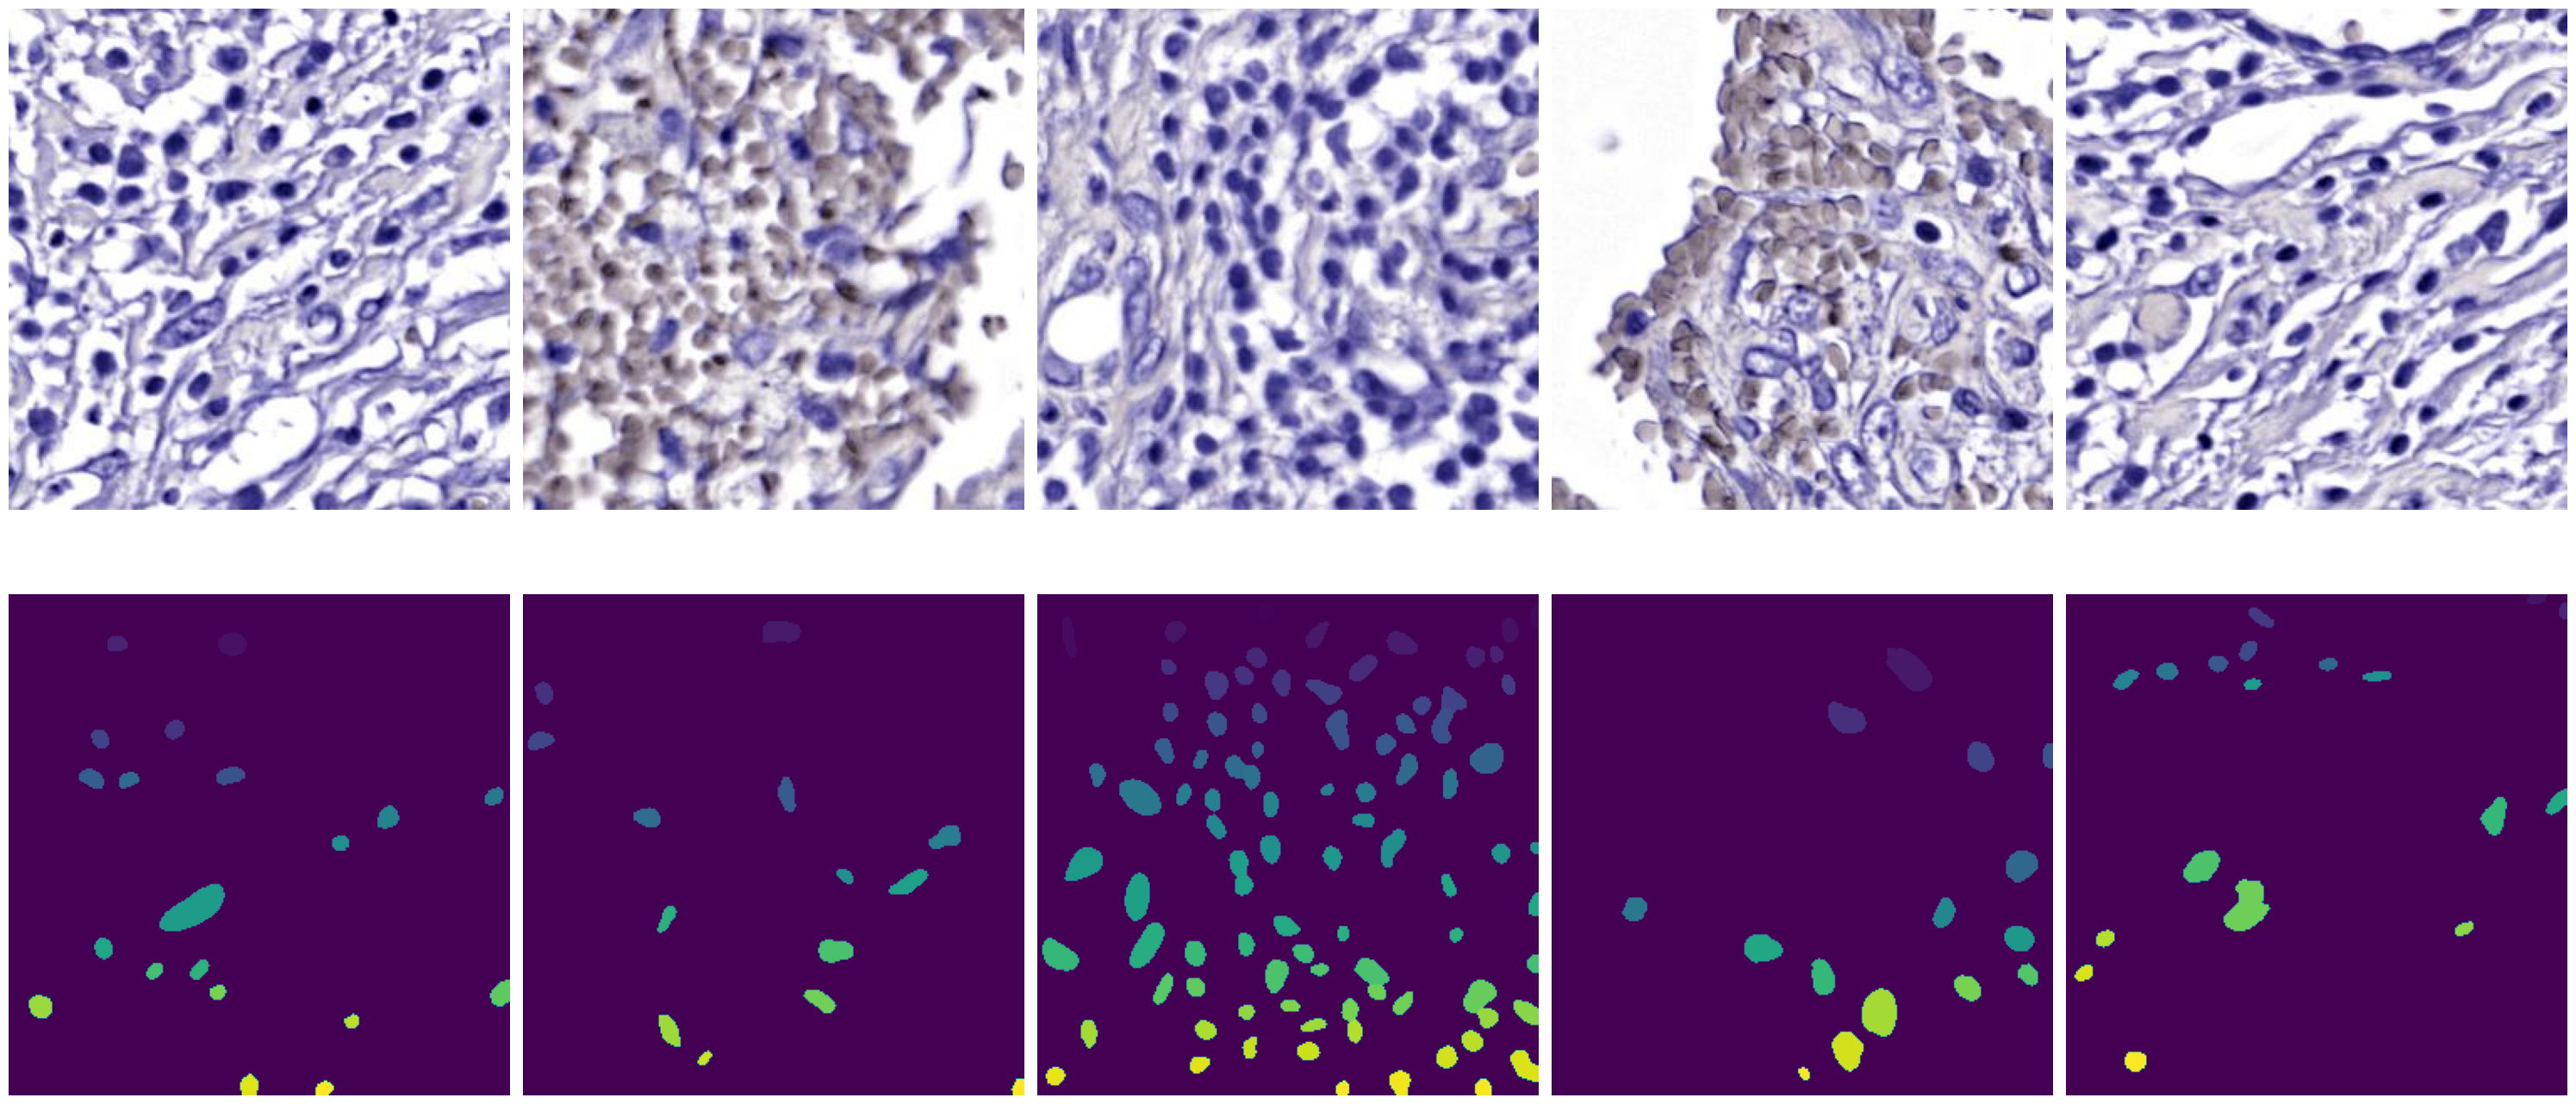

In [29]:
mask_list_1 = LIMEMask_FFPE_CD52_immune
mask_list_2 = LIMEMask_FFPE_VEGFA_immune
image_list_1 = imm_tiles
image_list_2 = imm_tiles

def load_image(path):
    return Image.open(path)

def load_mask(path):
    return path

def load_segments(segments):
    return segments

fig, axes = plt.subplots(2, 5, figsize=(30, 15))

for i in range(5):
    img = load_image(image_list_1[i])
    img_ax = axes[0, i]
    img_ax.imshow(img)
    img_ax.axis('off')

for i in range(5):
    seg = load_segments(cellpose_segments_immune[i])
    img_ax = axes[1, i]
    img_ax.imshow((seg))
    img_ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
mask_list_1 = LIMEMask_FFPE_CD52_cancer
mask_list_2 = LIMEMask_FFPE_VEGFA_cancer
image_list_1 = can_tiles
image_list_2 = can_tiles

def load_image(path):
    return Image.open(path)

def load_mask(path):
    return path

def load_segments(segments):
    return segments

fig, axes = plt.subplots(2, 5, figsize=(30, 15))

for i in range(5):
    img = load_image(image_list_1[i])
    img_ax = axes[0, i]
    img_ax.imshow(img)
    img_ax.axis('off')

for i in range(5):
    seg = load_segments(cellpose_segments_cancer[i])
    img_ax = axes[1, i]
    img_ax.imshow((seg))
    img_ax.axis('off')

plt.tight_layout()
plt.show()

#### Load the tiles and LIME results

In [ ]:
LIMEMask_FFPE_CD52_cancer = np.load(Path+"pickle/npy/LIMEMaskReg_FFPE_CD52_cancer_new5.npy")
LIMEMask_FFPE_CD52_immune = np.load(Path+"pickle/npy/LIMEMaskReg_FFPE_CD52_immune_new5.npy")
LIMEMask_FFPE_VEGFA_cancer = np.load(Path+"pickle/npy/LIMEMaskReg_FFPE_VEGFA_cancer_new5.npy")
LIMEMask_FFPE_VEGFA_immune = np.load(Path+"pickle/npy/LIMEMaskReg_FFPE_VEGFA_immune_new5.npy")

In [ ]:
mask_list_1 = LIMEMask_FFPE_CD52_immune
mask_list_2 = LIMEMask_FFPE_VEGFA_immune
image_list_1 = imm_tiles

# Function to load images and masks
def load_image(path):
    return Image.open(path)

def load_mask(path):
    return path

# Plotting
fig, axes = plt.subplots(2, 5, figsize=(35, 20))

for i in range(5):
    img = load_image(image_list_1[i])
    mask = load_mask(mask_list_1[i])
    img_ax = axes[0, i]
    img_ax.imshow(img)
    mask_img = img_ax.imshow(mask, cmap='RdYlBu_r', alpha=0.6)
    img_ax.axis('off')
    cbar = fig.colorbar(mask_img, ax=img_ax, fraction=0.045, pad=0.02)
    cbar.set_label('', fontsize=25)  
    cbar.ax.tick_params(labelsize=25)  
    
for i in range(5):
    img = load_image(image_list_1[i])
    mask = load_mask(mask_list_2[i])
    img_ax = axes[1, i]
    img_ax.imshow(img)
    mask_img = img_ax.imshow(mask, cmap='RdYlBu_r', alpha=0.6, 
                             vmin=np.min(load_mask(mask_list_1[i])),
                             vmax=np.max(load_mask(mask_list_1[i])))
    img_ax.axis('off')
    # Add colorbar to the right of the second row
    cbar = fig.colorbar(mask_img, ax=img_ax, fraction=0.045, pad=0.02)
    cbar.set_label('', fontsize=25)  
    cbar.ax.tick_params(labelsize=25)  

plt.tight_layout()
plt.show()

In [ ]:
mask_list_1 = LIMEMask_FFPE_CD52_cancer
mask_list_2 = LIMEMask_FFPE_VEGFA_cancer
image_list_1 = can_tiles

# Function to load images and masks
def load_image(path):
    return Image.open(path)

def load_mask(path):
    return path

# Plotting
fig, axes = plt.subplots(2, 5, figsize=(35, 20))

# Plot first row (mask_list_1 and image_list_1)
for i in range(5):
    img = load_image(image_list_1[i])
    mask = load_mask(mask_list_1[i])
    img_ax = axes[0, i]
    img_ax.imshow(img)
    mask_img = img_ax.imshow(mask, cmap='RdYlBu_r', alpha=0.6, 
                             vmin=np.min(load_mask(mask_list_2[i])),
                             vmax=np.max(load_mask(mask_list_2[i])))
    img_ax.axis('off')
    cbar = fig.colorbar(mask_img, ax=img_ax, fraction=0.045, pad=0.02)
    cbar.set_label('', fontsize=25)  
    cbar.ax.tick_params(labelsize=25)  

# Plot first row (mask_list_1 and image_list_1)
for i in range(5):
    img = load_image(image_list_1[i])
    mask = load_mask(mask_list_2[i])
    img_ax = axes[1, i]
    img_ax.imshow(img)
    mask_img = img_ax.imshow(mask, cmap='RdYlBu_r', alpha=0.6)
    img_ax.axis('off')
    cbar = fig.colorbar(mask_img, ax=img_ax, fraction=0.045, pad=0.02)
    cbar.set_label('', fontsize=25)  
    cbar.ax.tick_params(labelsize=25)  
    
plt.tight_layout()
plt.show()

#### ResNet50 features from last convolution block

In [17]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image as image_fun
import keras
from keras import backend as K
import pickle
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter

In [20]:
Path="/scratch/project/stseq/Onkar/STimage_v1/Outputs/"

with open(Path+"pickle/npy/"+'FFPE_cancer_paths_new5.pkl', 'rb') as file:
    cancer_tiles = pickle.load(file)
    
with open(Path+"pickle/npy/"+'FFPE_immune_paths_new5.pkl', 'rb') as file:
    immune_tiles = pickle.load(file)    

image_tiles = immune_tiles+cancer_tiles

In [21]:
model = ResNet50(weights='imagenet', pooling="avg", include_top = False)

/scratch/temp/10345326/ipykernel_3849929/2211190475.py:25: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  resized_image = im.resize((299, 299), Image.NEAREST)


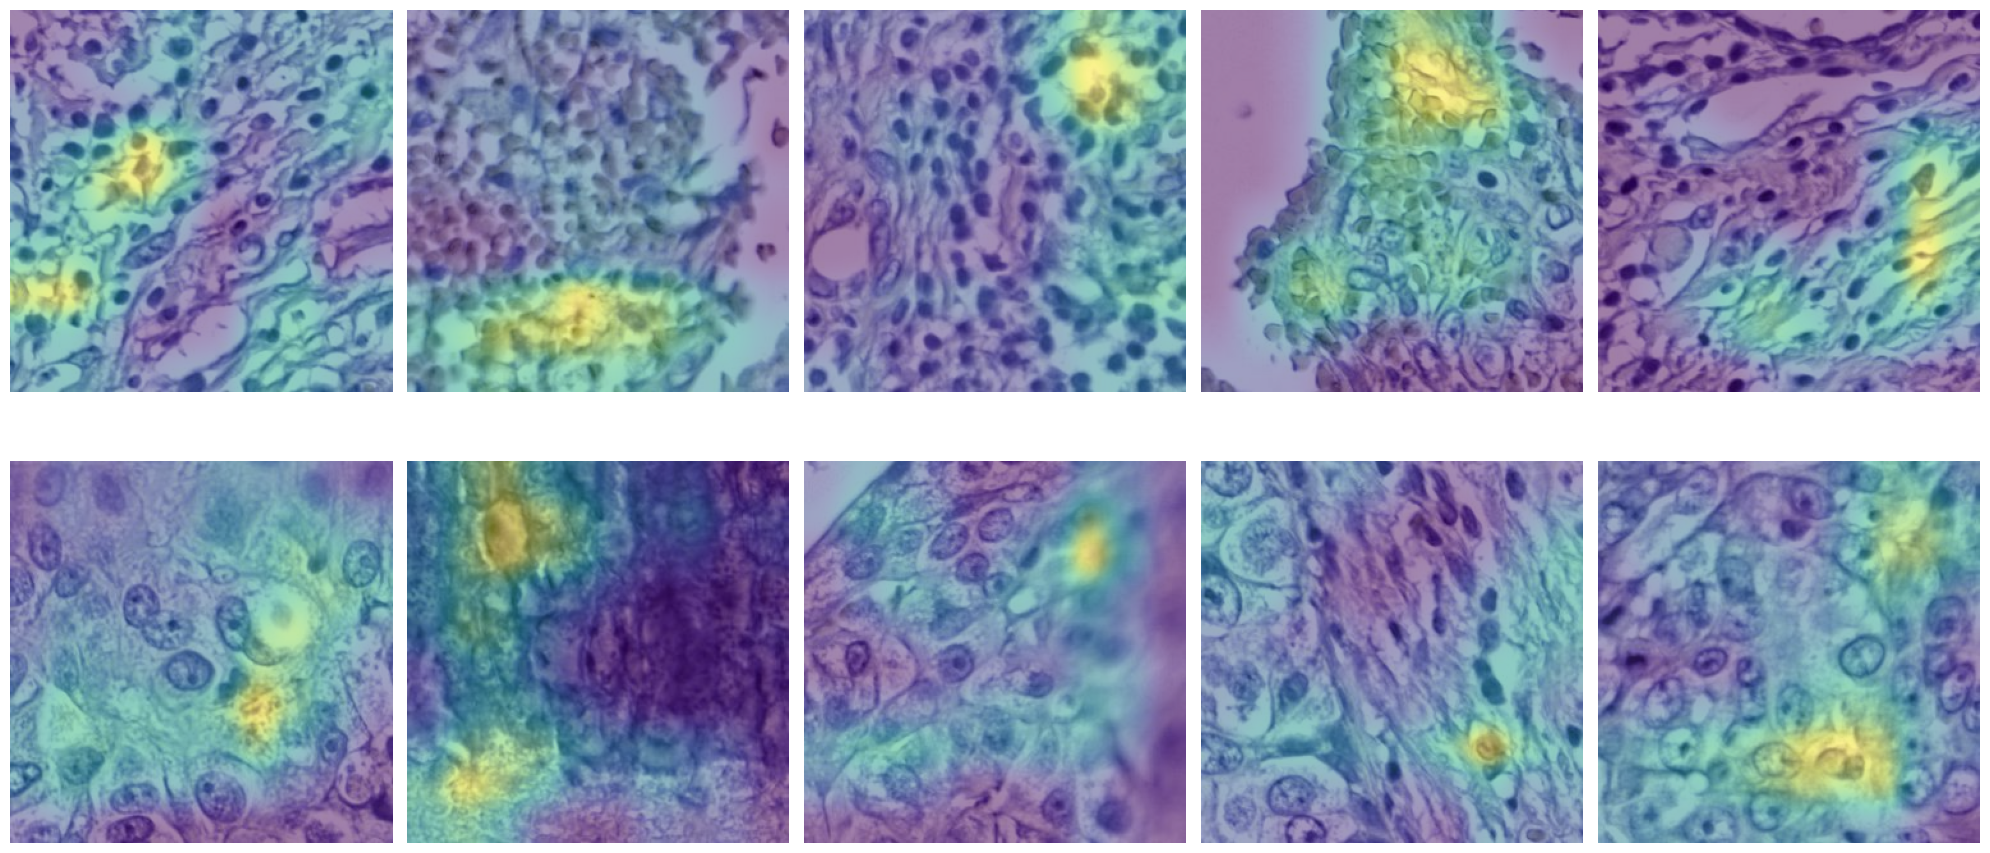

In [22]:
# Create a 10x10 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i in range(10):
    img = image_fun.load_img(image_tiles[i], target_size=(299, 299))
    x = image_fun.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer('conv5_block3_2_relu')
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(x)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((10, 10))

    scaled_array = (heatmap * 255).astype(np.uint8)
    im = Image.fromarray(scaled_array)
    resized_image = im.resize((299, 299), Image.NEAREST)
    smoothed_heatmap = gaussian_filter(resized_image, sigma=10)

    # Calculate row and column indices for subplots
    row, col = divmod(i, 5)
    
    # Plot the heatmap on the grid
    axes[row, col].imshow(smoothed_heatmap, cmap="viridis")
    axes[row, col].imshow(Image.open(image_tiles[i]), alpha=0.5)
    axes[row, col].axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()

#### True and Predicted gene expression for the tiles

In [34]:
tile[tile.obs.index.isin(data_FFPE_cancer_rs)].to_df()[["CD52","CDH1"]]

CD52      CDH1
ACGATACATAGAACTA-1-FFPE  0.693147  1.791759
CAACGGTTCTTGATAC-1-FFPE  0.693147  1.609438
CTGTATGGTGTAGAAA-1-FFPE  0.000000  1.609438
TAACAAAGGGAGAAGC-1-FFPE  0.693147  2.397895
TTATTAGAGCGTGTTC-1-FFPE  0.000000  0.000000

In [33]:
data_FFPE[data_FFPE.obs.index.isin(data_FFPE_cancer_rs)].to_df()[["CD52","CDH1"]]

CD52      CDH1
ACGATACATAGAACTA-1-FFPE  0.270515  1.960273
CAACGGTTCTTGATAC-1-FFPE  0.219585  1.060333
CTGTATGGTGTAGAAA-1-FFPE  0.209758  1.827016
TAACAAAGGGAGAAGC-1-FFPE  0.213641  2.459161
TTATTAGAGCGTGTTC-1-FFPE  0.167556  0.902712

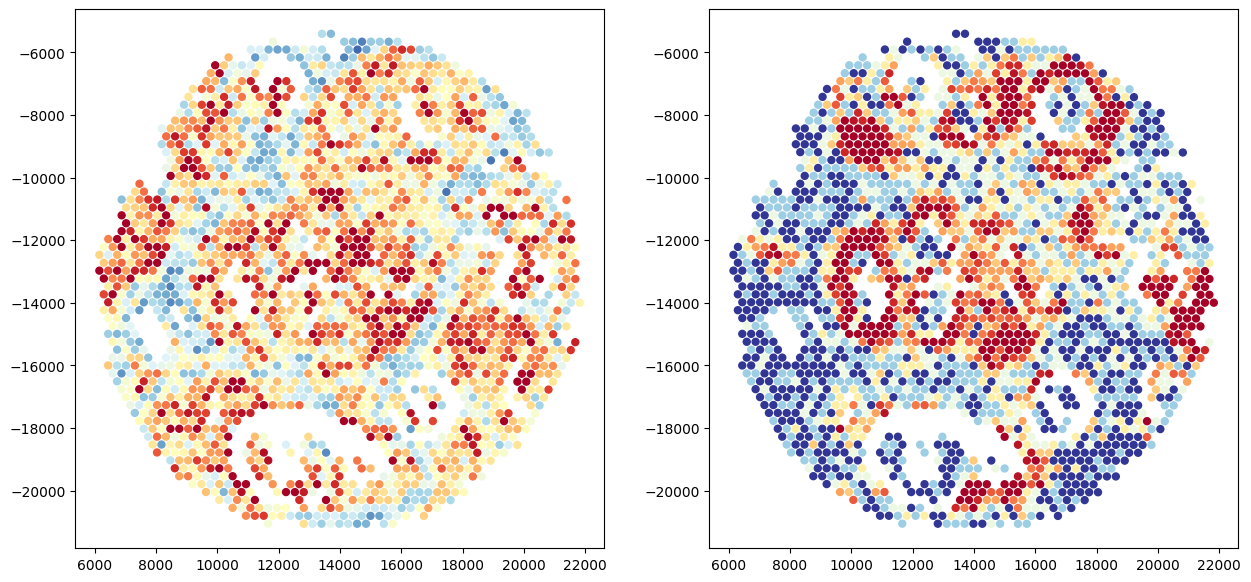

In [57]:
tile = test_adata[test_adata.obs["library_id"].isin(["FFPE"])]
# sc.pp.normalize_total(tile, inplace=True)
# sc.pp.log1p(tile)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.scatter(data_FFPE.obs["imagecol"],-data_FFPE.obs["imagerow"],s=25,c=data_FFPE.to_df()["VEGFA"],cmap="RdYlBu_r",
            vmin=0, vmax=1.0)
plt.subplot(1,2,2)
plt.scatter(tile.obs["imagecol"],-tile.obs["imagerow"],s=25,c=tile.to_df()["VEGFA"],cmap="RdYlBu_r", vmax=2.5)

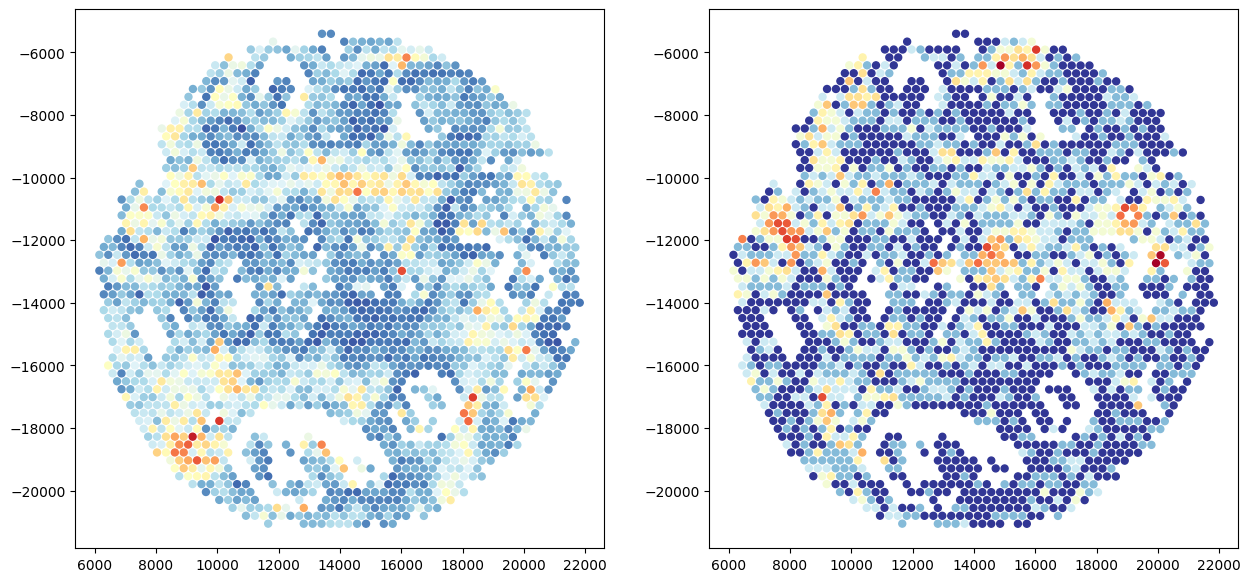

In [20]:
tile = test_adata[test_adata.obs["library_id"].isin(["FFPE"])]
# sc.pp.normalize_total(tile, inplace=True)
# sc.pp.log1p(tile)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.scatter(data_FFPE.obs["imagecol"],-data_FFPE.obs["imagerow"],s=25,c=data_FFPE.to_df()["CD52"],cmap="RdYlBu_r",
            vmin=0, vmax=1.5)
plt.subplot(1,2,2)
plt.scatter(tile.obs["imagecol"],-tile.obs["imagerow"],s=25,c=tile.to_df()["CD52"],cmap="RdYlBu_r", vmax=3.0)

#### Location of tiles

In [8]:
import pickle

with open(Path+"pickle/npy/"+'FFPE_cancer_paths_new5.pkl', 'rb') as file:
    cancer_tiles = pickle.load(file)
with open(Path+"pickle/npy/"+'FFPE_immune_paths_new5.pkl', 'rb') as file:
    immune_tiles = pickle.load(file)

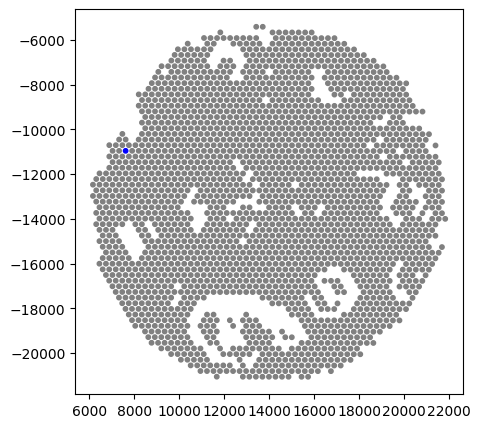

In [75]:
# Selection_region_FFPE.index(cancer_tiles[2])
# Selection_region_FFPE.index(cancer_tiles[3])
# Selection_region_FFPE.index(cancer_tiles[0])
# Selection_region_FFPE.index(cancer_tiles[3])
plt.figure(figsize=(5,5))
plt.scatter(tile.obs["imagecol"],-tile.obs["imagerow"],s=10,
            c=np.where(tile.obs["tile_path"]==immune_tiles[2],"blue","grey"))

#### Nuclei features

In [6]:
def only_segment_scores(Image_path, LIME_score):
    LIME_mask_score = []
    for i in tqdm(range(len(Image_path)), desc="Processing images"):
        try:
            mask = cellpose_segments(Image.open(Image_path[i]))
        except:
            mask = np.full((299, 299), 0)
        mask = np.where(mask == 0, 0, 1)
        minimum_val = LIME_score[i].min()
        mask_score = LIME_score[i] * mask
        mask_score = np.where(mask_score == 0, LIME_score[i].min(), mask_score)
        LIME_mask_score.append(mask_score)
    return LIME_mask_score

def score_pos_nuc(list_mat):
    nuclei_mask = []
    for i in range(0,len(list_mat)):
        mat = list_mat[i].copy()
        mat[mat <= 0] = 0
        nuclei_mask.append(mat)
    return nuclei_mask
    
def score_abv_0(list_mat):
    nuclei_mask = []
    for i in range(0,len(list_mat)):
        mat = list_mat[i].copy()
        mat[mat > 0] = 1
        nuclei_mask.append(mat)
    return nuclei_mask

In [9]:
LIMEMask_FFPE_CD52_cancer_scaled_nuc_seg = only_segment_scores(cancer_tiles, LIMEMask_FFPE_CD52_cancer)
LIMEMask_FFPE_CD52_cancer_scaled_nuc_seg_pos = score_pos_nuc(LIMEMask_FFPE_CD52_cancer_scaled_nuc_seg)
LIMEMask_FFPE_CD52_cancer_scaled_nuc_seg_abv_0 = score_abv_0(LIMEMask_FFPE_CD52_cancer_scaled_nuc_seg_pos)


LIMEMask_FFPE_CD52_immune_scaled_nuc_seg = only_segment_scores(immune_tiles, LIMEMask_FFPE_CD52_immune)
LIMEMask_FFPE_CD52_immune_scaled_nuc_seg_pos = score_pos_nuc(LIMEMask_FFPE_CD52_immune_scaled_nuc_seg)
LIMEMask_FFPE_CD52_immune_scaled_nuc_seg_abv_0 = score_abv_0(LIMEMask_FFPE_CD52_immune_scaled_nuc_seg_pos)

LIMEMask_FFPE_VEGFA_cancer_scaled_nuc_seg = only_segment_scores(cancer_tiles, LIMEMask_FFPE_VEGFA_cancer)
LIMEMask_FFPE_VEGFA_cancer_scaled_nuc_seg_pos = score_pos_nuc(LIMEMask_FFPE_VEGFA_cancer_scaled_nuc_seg)
LIMEMask_FFPE_VEGFA_cancer_scaled_nuc_seg_abv_0 = score_abv_0(LIMEMask_FFPE_VEGFA_cancer_scaled_nuc_seg_pos)

LIMEMask_FFPE_VEGFA_immune_scaled_nuc_seg = only_segment_scores(immune_tiles, LIMEMask_FFPE_VEGFA_immune)
LIMEMask_FFPE_VEGFA_immune_scaled_nuc_seg_pos = score_pos_nuc(LIMEMask_FFPE_VEGFA_immune_scaled_nuc_seg)
LIMEMask_FFPE_VEGFA_immune_scaled_nuc_seg_abv_0 = score_abv_0(LIMEMask_FFPE_VEGFA_immune_scaled_nuc_seg_pos)

Processing images:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-28 10:18:04,494 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:18:04,495 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:18:04,496 [INFO] >>>> using CPU
2024-08-28 10:18:04,498 [INFO] >> nuclei << model set to be used
2024-08-28 10:18:04,570 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:18:05,223 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:18:05,232 [INFO] channels set to [[0, 0]]
2024-08-28 10:18:05,232 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:18:14,014 [INFO] >>>> TOTAL TIME 8.78 sec


Processing images:  20%|██        | 1/5 [00:09<00:38,  9.69s/it]

2024-08-28 10:18:14,054 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:18:14,055 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:18:14,056 [INFO] >>>> using CPU
2024-08-28 10:18:14,057 [INFO] >> nuclei << model set to be used
2024-08-28 10:18:14,112 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:18:14,723 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:18:14,726 [INFO] channels set to [[0, 0]]
2024-08-28 10:18:14,727 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:18:23,186 [INFO] >>>> TOTAL TIME 8.46 sec


Processing images:  40%|████      | 2/5 [00:18<00:28,  9.39s/it]

2024-08-28 10:18:25,165 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:18:25,167 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:18:25,167 [INFO] >>>> using CPU
2024-08-28 10:18:25,168 [INFO] >> nuclei << model set to be used
2024-08-28 10:18:25,218 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:18:25,950 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:18:25,953 [INFO] channels set to [[0, 0]]
2024-08-28 10:18:25,953 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:18:34,555 [INFO] >>>> TOTAL TIME 8.60 sec


Processing images:  60%|██████    | 3/5 [00:30<00:20, 10.29s/it]

2024-08-28 10:18:34,598 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:18:34,599 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:18:34,600 [INFO] >>>> using CPU
2024-08-28 10:18:34,601 [INFO] >> nuclei << model set to be used
2024-08-28 10:18:34,645 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:18:35,253 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:18:35,257 [INFO] channels set to [[0, 0]]
2024-08-28 10:18:35,258 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:18:43,749 [INFO] >>>> TOTAL TIME 8.49 sec


Processing images:  80%|████████  | 4/5 [00:39<00:09,  9.86s/it]

2024-08-28 10:18:43,785 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:18:43,786 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:18:43,787 [INFO] >>>> using CPU
2024-08-28 10:18:43,789 [INFO] >> nuclei << model set to be used
2024-08-28 10:18:43,842 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:18:44,445 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:18:44,452 [INFO] channels set to [[0, 0]]
2024-08-28 10:18:44,453 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:18:53,348 [INFO] >>>> TOTAL TIME 8.90 sec


Processing images:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-28 10:18:53,383 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:18:53,384 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:18:53,385 [INFO] >>>> using CPU
2024-08-28 10:18:53,385 [INFO] >> nuclei << model set to be used
2024-08-28 10:18:53,430 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:18:54,020 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:18:54,027 [INFO] channels set to [[0, 0]]
2024-08-28 10:18:54,028 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:19:02,628 [INFO] >>>> TOTAL TIME 8.60 sec


Processing images:  20%|██        | 1/5 [00:09<00:37,  9.28s/it]

2024-08-28 10:19:02,663 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:19:02,664 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:19:02,664 [INFO] >>>> using CPU
2024-08-28 10:19:02,665 [INFO] >> nuclei << model set to be used
2024-08-28 10:19:02,713 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:19:03,312 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:19:03,316 [INFO] channels set to [[0, 0]]
2024-08-28 10:19:03,318 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:19:11,939 [INFO] >>>> TOTAL TIME 8.62 sec


Processing images:  40%|████      | 2/5 [00:18<00:27,  9.30s/it]

2024-08-28 10:19:11,974 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:19:11,975 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:19:11,976 [INFO] >>>> using CPU
2024-08-28 10:19:11,977 [INFO] >> nuclei << model set to be used
2024-08-28 10:19:12,046 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:19:12,637 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:19:12,646 [INFO] channels set to [[0, 0]]
2024-08-28 10:19:12,646 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:19:21,242 [INFO] >>>> TOTAL TIME 8.60 sec


Processing images:  60%|██████    | 3/5 [00:27<00:18,  9.30s/it]

2024-08-28 10:19:21,286 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:19:21,286 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:19:21,287 [INFO] >>>> using CPU
2024-08-28 10:19:21,288 [INFO] >> nuclei << model set to be used
2024-08-28 10:19:21,337 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:19:21,933 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:19:21,937 [INFO] channels set to [[0, 0]]
2024-08-28 10:19:21,939 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:19:30,490 [INFO] >>>> TOTAL TIME 8.55 sec


Processing images:  80%|████████  | 4/5 [00:37<00:09,  9.28s/it]

2024-08-28 10:19:30,522 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:19:30,523 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:19:30,524 [INFO] >>>> using CPU
2024-08-28 10:19:30,525 [INFO] >> nuclei << model set to be used
2024-08-28 10:19:30,570 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:19:31,161 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:19:31,164 [INFO] channels set to [[0, 0]]
2024-08-28 10:19:31,165 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:19:39,575 [INFO] >>>> TOTAL TIME 8.41 sec


Processing images:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-28 10:19:39,595 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:19:39,596 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:19:39,596 [INFO] >>>> using CPU
2024-08-28 10:19:39,597 [INFO] >> nuclei << model set to be used
2024-08-28 10:19:39,641 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:19:40,204 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:19:40,206 [INFO] channels set to [[0, 0]]
2024-08-28 10:19:40,207 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:19:48,478 [INFO] >>>> TOTAL TIME 8.27 sec


Processing images:  20%|██        | 1/5 [00:08<00:35,  8.90s/it]

2024-08-28 10:19:48,494 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:19:48,494 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:19:48,495 [INFO] >>>> using CPU
2024-08-28 10:19:48,495 [INFO] >> nuclei << model set to be used
2024-08-28 10:19:48,540 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:19:49,115 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:19:49,117 [INFO] channels set to [[0, 0]]
2024-08-28 10:19:49,118 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:19:57,352 [INFO] >>>> TOTAL TIME 8.23 sec


Processing images:  40%|████      | 2/5 [00:17<00:26,  8.88s/it]

2024-08-28 10:19:57,369 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:19:57,370 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:19:57,370 [INFO] >>>> using CPU
2024-08-28 10:19:57,371 [INFO] >> nuclei << model set to be used
2024-08-28 10:19:57,417 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:19:57,989 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:19:57,997 [INFO] channels set to [[0, 0]]
2024-08-28 10:19:57,998 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:20:06,327 [INFO] >>>> TOTAL TIME 8.33 sec


Processing images:  60%|██████    | 3/5 [00:26<00:17,  8.93s/it]

2024-08-28 10:20:06,343 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:20:06,344 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:20:06,345 [INFO] >>>> using CPU
2024-08-28 10:20:06,346 [INFO] >> nuclei << model set to be used
2024-08-28 10:20:06,390 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:20:06,948 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:20:06,951 [INFO] channels set to [[0, 0]]
2024-08-28 10:20:06,952 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:20:15,447 [INFO] >>>> TOTAL TIME 8.50 sec


Processing images:  80%|████████  | 4/5 [00:35<00:09,  9.00s/it]

2024-08-28 10:20:15,464 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:20:15,464 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:20:15,465 [INFO] >>>> using CPU
2024-08-28 10:20:15,466 [INFO] >> nuclei << model set to be used
2024-08-28 10:20:15,512 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:20:16,084 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:20:16,092 [INFO] channels set to [[0, 0]]
2024-08-28 10:20:16,093 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:20:24,524 [INFO] >>>> TOTAL TIME 8.43 sec


Processing images:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-28 10:20:24,544 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:20:24,544 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:20:24,545 [INFO] >>>> using CPU
2024-08-28 10:20:24,546 [INFO] >> nuclei << model set to be used
2024-08-28 10:20:24,590 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:20:25,162 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:20:25,169 [INFO] channels set to [[0, 0]]
2024-08-28 10:20:25,169 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:20:33,636 [INFO] >>>> TOTAL TIME 8.47 sec


Processing images:  20%|██        | 1/5 [00:09<00:36,  9.11s/it]

2024-08-28 10:20:33,651 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:20:33,652 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:20:33,652 [INFO] >>>> using CPU
2024-08-28 10:20:33,653 [INFO] >> nuclei << model set to be used
2024-08-28 10:20:33,698 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:20:34,302 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:20:34,306 [INFO] channels set to [[0, 0]]
2024-08-28 10:20:34,306 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:20:42,717 [INFO] >>>> TOTAL TIME 8.41 sec


Processing images:  40%|████      | 2/5 [00:18<00:27,  9.09s/it]

2024-08-28 10:20:42,734 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:20:42,734 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:20:42,735 [INFO] >>>> using CPU
2024-08-28 10:20:42,736 [INFO] >> nuclei << model set to be used
2024-08-28 10:20:42,783 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:20:43,383 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:20:43,390 [INFO] channels set to [[0, 0]]
2024-08-28 10:20:43,391 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:20:51,843 [INFO] >>>> TOTAL TIME 8.45 sec


Processing images:  60%|██████    | 3/5 [00:27<00:18,  9.11s/it]

2024-08-28 10:20:51,860 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:20:51,860 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:20:51,861 [INFO] >>>> using CPU
2024-08-28 10:20:51,862 [INFO] >> nuclei << model set to be used
2024-08-28 10:20:51,908 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:20:52,487 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:20:52,490 [INFO] channels set to [[0, 0]]
2024-08-28 10:20:52,491 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:21:00,921 [INFO] >>>> TOTAL TIME 8.43 sec


Processing images:  80%|████████  | 4/5 [00:36<00:09,  9.10s/it]

2024-08-28 10:21:00,940 [INFO] WRITING LOG OUTPUT TO /home/s4634945/.cellpose/run.log
2024-08-28 10:21:00,940 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117
2024-08-28 10:21:00,941 [INFO] >>>> using CPU
2024-08-28 10:21:00,941 [INFO] >> nuclei << model set to be used
2024-08-28 10:21:00,989 [INFO] >>>> loading model /home/s4634945/.cellpose/models/nucleitorch_0
2024-08-28 10:21:01,569 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-28 10:21:01,572 [INFO] channels set to [[0, 0]]
2024-08-28 10:21:01,573 [INFO] ~~~ FINDING MASKS ~~~
2024-08-28 10:21:10,058 [INFO] >>>> TOTAL TIME 8.49 sec


Processing images: 100%|██████████| 5/5 [00:45<00:00,  9.11s/it]


#### Positive segments

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(2,5,1)
plt.imshow(LIMEMask_FFPE_CD52_cancer_scaled_nuc_seg_pos[0])
plt.subplot(2,5,2)
plt.imshow(LIMEMask_FFPE_CD52_cancer_scaled_nuc_seg_pos[1])
plt.subplot(2,5,3)
plt.imshow(LIMEMask_FFPE_CD52_cancer_scaled_nuc_seg_pos[2])
plt.subplot(2,5,4)
plt.imshow(LIMEMask_FFPE_CD52_cancer_scaled_nuc_seg_pos[3])
plt.subplot(2,5,5)
plt.imshow(LIMEMask_FFPE_CD52_cancer_scaled_nuc_seg_pos[4])
plt.subplot(2,5,6)
plt.imshow(LIMEMask_FFPE_VEGFA_cancer_scaled_nuc_seg_pos[0])
plt.subplot(2,5,7)
plt.imshow(LIMEMask_FFPE_VEGFA_cancer_scaled_nuc_seg_pos[1])
plt.subplot(2,5,8)
plt.imshow(LIMEMask_FFPE_VEGFA_cancer_scaled_nuc_seg_pos[2])
plt.subplot(2,5,9)
plt.imshow(LIMEMask_FFPE_VEGFA_cancer_scaled_nuc_seg_pos[3])
plt.subplot(2,5,10)
plt.imshow(LIMEMask_FFPE_VEGFA_cancer_scaled_nuc_seg_pos[4])

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(2,5,1)
plt.imshow(LIMEMask_FFPE_CD52_immune_scaled_nuc_seg_pos[0])
plt.subplot(2,5,2)
plt.imshow(LIMEMask_FFPE_CD52_immune_scaled_nuc_seg_pos[1])
plt.subplot(2,5,3)
plt.imshow(LIMEMask_FFPE_CD52_immune_scaled_nuc_seg_pos[2])
plt.subplot(2,5,4)
plt.imshow(LIMEMask_FFPE_CD52_immune_scaled_nuc_seg_pos[3])
plt.subplot(2,5,5)
plt.imshow(LIMEMask_FFPE_CD52_immune_scaled_nuc_seg_pos[4])
plt.subplot(2,5,6)
plt.imshow(LIMEMask_FFPE_VEGFA_immune_scaled_nuc_seg_pos[0])
plt.subplot(2,5,7)
plt.imshow(LIMEMask_FFPE_VEGFA_immune_scaled_nuc_seg_pos[1])
plt.subplot(2,5,8)
plt.imshow(LIMEMask_FFPE_VEGFA_immune_scaled_nuc_seg_pos[2])
plt.subplot(2,5,9)
plt.imshow(LIMEMask_FFPE_VEGFA_immune_scaled_nuc_seg_pos[3])
plt.subplot(2,5,10)
plt.imshow(LIMEMask_FFPE_VEGFA_immune_scaled_nuc_seg_pos[4])

In [119]:
from skimage import measure
def nuclei_features(masks):
    all_features = []

    for i, mask in enumerate(masks):
        labeled_mask = measure.label(mask)

        properties = measure.regionprops(labeled_mask)

        for prop in properties:
            area = prop.area
            roundness = (4 * np.pi * area) / (prop.perimeter ** 2) if prop.perimeter > 0 else 0
            centroid = prop.centroid

            features = {
                'Mask Index': i,
                'Label': prop.label,
                'Area': area,
                'Roundness': roundness,
                'Centroid': centroid
            }

            all_features.append(features)
    final_df = pd.DataFrame(all_features)
    return final_df

In [120]:
VEGFA_immune = nuclei_features(LIMEMask_FFPE_VEGFA_immune_scaled_nuc_seg_abv_0)
VEGFA_immune["region"] = "immune"
VEGFA_immune["gene"] = "VEGFA"
CD52_immune = nuclei_features(LIMEMask_FFPE_CD52_immune_scaled_nuc_seg_abv_0)
CD52_immune["region"] = "immune"
CD52_immune["gene"] = "CD52"
VEGFA_cancer = nuclei_features(LIMEMask_FFPE_VEGFA_cancer_scaled_nuc_seg_abv_0)
VEGFA_cancer["region"] = "cancer"
VEGFA_cancer["gene"] = "VEGFA"
CD52_cancer = nuclei_features(LIMEMask_FFPE_CD52_cancer_scaled_nuc_seg_abv_0)
CD52_cancer["region"] = "cancer"
CD52_cancer["gene"] = "CD52"
df = pd.concat([VEGFA_immune,VEGFA_cancer,CD52_immune,CD52_cancer])

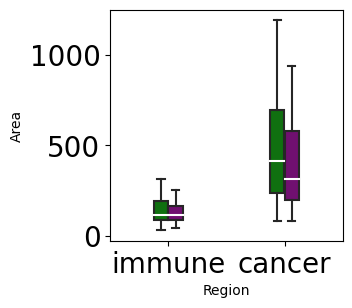

In [122]:
plt.figure(figsize=(3,3))
import seaborn as sns
PROPS = {
    'medianprops':{'color':'white'}}
ax = sns.boxplot(x='region', y='Area', data=df, width=0.25,hue='gene',
                 palette={"VEGFA":"Green","CD52":"Purple"},
                 showfliers=False,**PROPS)
plt.xlabel('Region')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.get_legend().remove()